In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
import numpy as np
import torch
import falkon
import os, sys
import time
import matplotlib.pyplot as plt
import math
from libsvmdata import fetch_libsvm
import libsvmdata

In [3]:
sys.path.append("../benchmark")

In [173]:
import falkon
from falkon.hypergrad.complexity_reg import GPComplexityReg, SimpleFalkonComplexityReg, TrainableSGPR
from falkon.hypergrad.common import test_train_predict
from summary import get_writer
writer = get_writer("test")

## What to do here

 - Download SVMLight datasets
 - Run the SGPR with RBF kernel optimizing centers
 - Compare with the PCA centers
 
 
We use LessIsMore notation to express the different projected kernel-ridge problems.


We have that $Z_m$ is the projected feature-map. In the case of Nystrom uniform sampling it is the kernel feature-map $\phi$ applied to the chosen samples $\tilde{x}_i, \dots, \tilde{x}_m$.

The solution to the learning problem is
$$
\tilde{f}_m(x) = \sum_{i=1}^m \tilde{\alpha}_i z_i(x)
$$
where the coefficient vector is
$$
\tilde{\alpha} = (Z_m Z_n^\top Z_n Z_m^\top + \lambda n Z_m Z_m^\top)^\dagger Z_m Z_n^\top Y
$$

Let $K = Z_n Z_n^\top$ be the kernel matrix with eigendecomposition $K = \sum_{i=1}^n \sigma_i u_i u_i^\top$. By choosing $Z_m = U_m^\top Z_n$ we 

In [117]:
def compare_ker_fro(model, X):
    centers = model.centers.detach()
    M = centers.shape[0]
    kernel = falkon.kernels.GaussianKernel(model.sigma.detach(), falkon_opt)
    
    # Nystrom B, G
    Bnm_nys = kernel(X, centers)
    Gmm_nys = kernel(centers, centers)
    # SVD B, G
    full_kernel = kernel(X, X)
    u, s, v = torch.svd(full_kernel)
    Bnm_svd = full_kernel @ u[:, :M]
    Gmm_svd = u[:,:M].T @ full_kernel @ u[:, :M]
    
    Ktilde_nys = Bnm_nys @ torch.pinverse(Gmm_nys) @ Bnm_nys.T
    Ktilde_svd = Bnm_svd @ torch.pinverse(Gmm_svd) @ Bnm_svd.T
    Ktilde_svd_2 = u[:, :M] @ torch.diag(s[:M]) @ u[:, :M].T
#     torch.testing.assert_allclose(Ktilde_svd, Ktilde_svd_2)
    
    return torch.sum((Ktilde_nys - Ktilde_svd)**2)
def compare_ker_tr(model, X):
    centers = model.centers.detach()
    M = centers.shape[0]
    kernel = falkon.kernels.GaussianKernel(model.sigma.detach(), falkon_opt)
    
    # Nystrom B, G
    Bnm_nys = kernel(X, centers)
    Gmm_nys = kernel(centers, centers)
    # SVD B, G
    full_kernel = kernel(X, X)
    u, s, v = torch.svd(full_kernel)
    Bnm_svd = full_kernel @ u[:, :M]
    Gmm_svd = u[:,:M].T @ full_kernel @ u[:, :M]
    
    Ktilde_nys = Bnm_nys @ torch.pinverse(Gmm_nys) @ Bnm_nys.T
    Ktilde_svd = Bnm_svd @ torch.pinverse(Gmm_svd) @ Bnm_svd.T
    Ktilde_svd_2 = u[:, :M] @ torch.diag(s[:M]) @ u[:, :M].T
    torch.testing.assert_allclose(Ktilde_svd, Ktilde_svd_2)
    
    return torch.trace(Ktilde_nys - Ktilde_svd)

In [6]:
def simple_solve_nkrr(Bnm, Gmm, Y, la):
    h = Bnm.T @ Bnm + la * Bnm.shape[0] * Gmm
    alpha = torch.pinverse(h) @ Bnm.T @ Y
    return alpha
def simple_solve_krr(kernel, Xtr, Ytr, la):
    alpha = (torch.pinverse(kernel(Xtr, Xtr) + 
                           Xtr.shape[0] * la * torch.eye(Xtr.shape[0])) 
             @ Ytr)
    return alpha
def simple_pred_nkrr(Bnm, alpha):
    return Bnm @ alpha
def simple_pred_krr(kernel, Xtr, Xts, alpha):
    return kernel(Xts, Xtr) @ alpha

In [181]:
def mse(y_true, y_pred):
    if not isinstance(y_true, np.ndarray):
        y_true = y_true.numpy()
    if not isinstance(y_pred, np.ndarray):
        y_pred = y_pred.numpy()
        
    return np.mean((y_true.reshape(-1) - y_pred.reshape(-1))**2), "mse"
def preprocess_dataset(X, Y, n_train):
    shuffle = np.random.permutation(X.shape[0])
    X = X[shuffle]
    Y = Y[shuffle]
    Xtr = X[:n_train].clone()#.to(dtype=torch.float64)
    Ytr = Y[:n_train].clone()#.to(dtype=torch.float64)
    Xts = X[n_train:].clone()#.to(dtype=torch.float64)
    Yts = Y[n_train:].clone()#.to(dtype=torch.float64)
    mean = Xtr.mean(axis=0, keepdims=True)
    std = Xtr.std(axis=0, keepdims=True)
    Xtr -= mean
    Xts -= mean
    Xtr /= std
    Xts /= std
    return Xtr, Ytr, Xts, Yts

In [8]:
def get_random_bg(Xtr, M, Xts=None):
    centers_init = torch.randn(M, Xtr.shape[1], dtype=Xtr.dtype)
    Bnm = kernel(Xtr, centers_init)
    Gmm = kernel(centers_init, centers_init)
    Bnm_test = None
    if Xts is not None:
        Bnm_test = kernel(Xts, centers_init)
    return Bnm, Gmm, Bnm_test
def get_nystrom_bg(Xtr, M, Xts=None):
    centers_init = Xtr[np.random.choice(Xtr.shape[0], size=M, replace=False), :]
    Bnm = kernel(Xtr, centers_init)
    Gmm = kernel(centers_init, centers_init)
    Bnm_test = None
    if Xts is not None:
        Bnm_test = kernel(Xts, centers_init)
    return Bnm, Gmm, Bnm_test
def get_svd_bg(Xtr, M, Xts=None):
    full_kernel = kernel(Xtr, Xtr)
    u, s, v = torch.svd(full_kernel)
    Bnm = full_kernel @ u[:, :M]
    Gmm = u[:,:M].T @ full_kernel @ u[:, :M]
    Bnm_test = None
    if Xts is not None:
        Bnm_test = kernel(Xts, Xtr) @ u[:, :M]
    return Bnm, Gmm, Bnm_test
def get_train_error(Bnm, Bnm_test, Gmm, Ytr, Yts, penalty):
    alpha = simple_solve_nkrr(Bnm, Gmm, Ytr, penalty)
    train_preds = simple_pred_nkrr(Bnm, alpha)
    err, name = mse(Ytr, train_preds)
    return err
def get_test_error(Bnm, Bnm_test, Gmm, Ytr, Yts, penalty):
    alpha = simple_solve_nkrr(Bnm, Gmm, Ytr, penalty)
    test_preds = simple_pred_nkrr(Bnm_test, alpha)
    err, name = mse(Yts, test_preds)
    return err
def krr_train_error(Xtr, Xts, Ytr, Yts, kernel, la):
    alpha = simple_solve_krr(kernel, Xtr, Ytr, la)
    train_preds = simple_pred_krr(kernel, Xtr, Xtr, alpha)
    err, name = mse(Ytr, train_preds)
    return err
def krr_test_error(Xtr, Xts, Ytr, Yts, kernel, la):
    alpha = simple_solve_krr(kernel, Xtr, Ytr, la)
    test_preds = simple_pred_krr(kernel, Xtr, Xts, alpha)
    err, name = mse(Yts, test_preds)
    return err

In [9]:
dset_sigmas_15la = {
    "cpusmall": 8.,
    "abalone": 20.,
    "space_ga": 3.,
    "svmguide1": 3.,
    "cadata": 5.,
}

In [112]:
def load_dset(dset_name, n_train=1000, penalty=8., sigma=None, dtype=torch.float32):
    X, y = fetch_libsvm(dset_name)
    X = torch.from_numpy(np.asarray(X.todense())).to(dtype=dtype)
    Y = torch.from_numpy(y.reshape(-1, 1)).to(dtype=dtype)
    print(X.shape, Y.shape)
    Xtr, Ytr, Xts, Yts = preprocess_dataset(X, Y, n_train=n_train)

    penalty_init = torch.tensor(penalty, dtype=Xtr.dtype)
    if sigma is not None:
        sigma_init = torch.tensor([sigma], dtype=Xtr.dtype)
    else:
        sigma_init = torch.tensor([dset_sigmas_15la[dset_name]], dtype=Xtr.dtype)

    falkon_opt = falkon.FalkonOptions(keops_active="no", use_cpu=True)
    kernel = falkon.kernels.GaussianKernel(sigma_init, opt=falkon_opt)
    
    return Xtr, Ytr, Xts, Yts, penalty_init, sigma_init, kernel

### Short analysis of any given dataset to look for best sigma

In [11]:
dset_name = "space_ga"
X, y = fetch_libsvm(dset_name)
X = torch.from_numpy(np.asarray(X.todense())).float()
Y = torch.from_numpy(y.reshape(-1, 1)).float()
print(X.shape, Y.shape)
Xtr, Ytr, Xts, Yts = preprocess_dataset(X, Y, n_train=1000)

Dataset: space_ga
torch.Size([3107, 6]) torch.Size([3107, 1])


In [12]:
penalty_init = torch.tensor(8., dtype=Xtr.dtype)
sigma_init = torch.tensor([dset_sigmas_15la[dset_name]], dtype=Xtr.dtype)

falkon_opt = falkon.FalkonOptions(keops_active="no", use_cpu=True)
kernel = falkon.kernels.GaussianKernel(sigma_init, opt=falkon_opt)

In [14]:
print(krr_train_error(Xtr, Xts, Ytr, Yts, kernel, torch.exp(-penalty_init)))
print(krr_test_error(Xtr, Xts, Ytr, Yts, kernel, torch.exp(-penalty_init)))

tensor(0.0127, dtype=torch.float64)
tensor(0.0157, dtype=torch.float64)


## Error vs. M plots.

We solve the learning problem in closed-form for different values of `M`. We compare the error obtained for different versions of the problem:

 1. Full kernel-ridge regression is the baseline, does not change with M.
 2. Nystrom KRR with uniformly chosen centers
 3. ~Nystrom KRR with random Gaussian centers
 4. ~Nystrom KRR with SVD centers

In [13]:
def error_evolution(m_list, num_reps, err_type, Xtr, Xts, Ytr, Yts, kernel, la):
    if err_type == "train":
        krr_err_fn = krr_train_error
        get_err_fn = get_train_error
    else:
        krr_err_fn = krr_test_error
        get_err_fn = get_test_error
    
    Kfull = kernel(Xtr, Xtr)
    err_krr = krr_err_fn(Xtr, Xts, Ytr, Yts, kernel, la)

    err_random, err_nystrom, err_svd = [], [], []
    err_random_std, err_nystrom_std = [], []
    fro_random, fro_nystrom, fro_svd = [], [], []
    for m in m_list:
        errs = []
        for i in range(num_reps):
            Bnm, Gmm, Bnm_test = get_random_bg(Xtr, m, Xts)
            errs.append(get_err_fn(Bnm, Bnm_test, Gmm, Ytr, Yts, la))
        err_random.append(np.mean(errs))
        err_random_std.append(np.std(errs))

        errs = []
        for i in range(num_reps):
            Bnm, Gmm, Bnm_test = get_nystrom_bg(Xtr, m, Xts)
            errs.append(get_err_fn(Bnm, Bnm_test, Gmm, Ytr, Yts, la))
        err_nystrom.append(np.mean(errs))
        err_nystrom_std.append(np.std(errs))

        Bnm, Gmm, Bnm_test = get_svd_bg(Xtr, m, Xts)
        err_svd.append(get_err_fn(Bnm, Bnm_test, Gmm, Ytr, Yts, la))

        # Frobenius error to full kernel
        Bnm, Gmm, Bnm_test = get_random_bg(Xtr, m, Xts)
        Ktilde = Bnm @ torch.pinverse(Gmm) @ Bnm.T
        fro_random.append(torch.sum((Kfull - Ktilde)**2))

        Bnm, Gmm, Bnm_test = get_nystrom_bg(Xtr, m, Xts)
        Ktilde = Bnm @ torch.pinverse(Gmm) @ Bnm.T
        fro_nystrom.append(torch.sum((Kfull - Ktilde)**2))

        Bnm, Gmm, Bnm_test = get_svd_bg(Xtr, m, Xts)
        Ktilde = Bnm @ torch.pinverse(Gmm) @ Bnm.T
        fro_svd.append(torch.sum((Kfull - Ktilde)**2))
        print(m, end=".")
    return {
        "err_random": np.asarray(err_random),
        "err_nystrom": np.asarray(err_nystrom),
        "err_svd": np.asarray(err_svd),
        "err_random_std": np.asarray(err_random_std),
        "err_nystrom_std": np.asarray(err_nystrom_std),
        "fro_random": np.asarray(fro_random),
        "fro_nystrom": np.asarray(fro_nystrom),
        "fro_svd": np.asarray(fro_svd),
        "err_krr": err_krr
    }

In [14]:
def plot_error_evolution(m_list, data, err_type, figax=None, title=""):
    if figax is None:
        fig, ax = plt.subplots()
    else:
        fig, ax = figax
    ax1 = ax.twinx()
    # ax.plot(m_list, err_data["err_random"], label="random", color="#381642")
    # ax.fill_between(m_list, 
    #                 err_data["err_random"] - err_data["err_random_std"], 
    #                 err_data["err_random"] + err_data["err_random_std"],
    #                 color="#7f528c", alpha=0.2)
    # ax1.plot(m_list, err_data["fro_random"], color="#381642", linestyle="--", label="random")

    ax.plot(m_list, data["err_nystrom"], label="nystrom", color="#1a3f93")
    ax.fill_between(m_list, 
                    data["err_nystrom"] - data["err_nystrom_std"], 
                    data["err_nystrom"] + data["err_nystrom_std"],
                    color="#738bc4", alpha=0.2)
    ax1.plot(m_list, data["fro_nystrom"], color="#1a3f93", linestyle="--", label="nystrom")

    ax.plot(m_list, data["err_svd"], label="SVD", color="#366d0e")
    ax1.plot(m_list, data["fro_svd"], color="#366d0e", linestyle="--", label="SVD")

    ax.plot(m_list, [data["err_krr"].item()] * len(m_list), color="red", label="Full KRR")

    ax1.set_yscale("log")

    ax.legend(loc="best")
    ax.grid()

    ax.set_xlabel("M")
    ax.set_ylabel("%s MSE" % (err_type))
    ax1.set_ylabel("Frobenius norm to full kernel")
    ax.set_title(title)
    return fig, ax

Dataset: cpusmall
torch.Size([8192, 12]) torch.Size([8192, 1])
1.4.7.10.13.16.19.22.25.28.31.34.37.40.43.46.49.52.55.58.1.4.7.10.13.16.19.22.25.28.31.34.37.40.43.46.49.52.55.58.

/home/giacomo/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


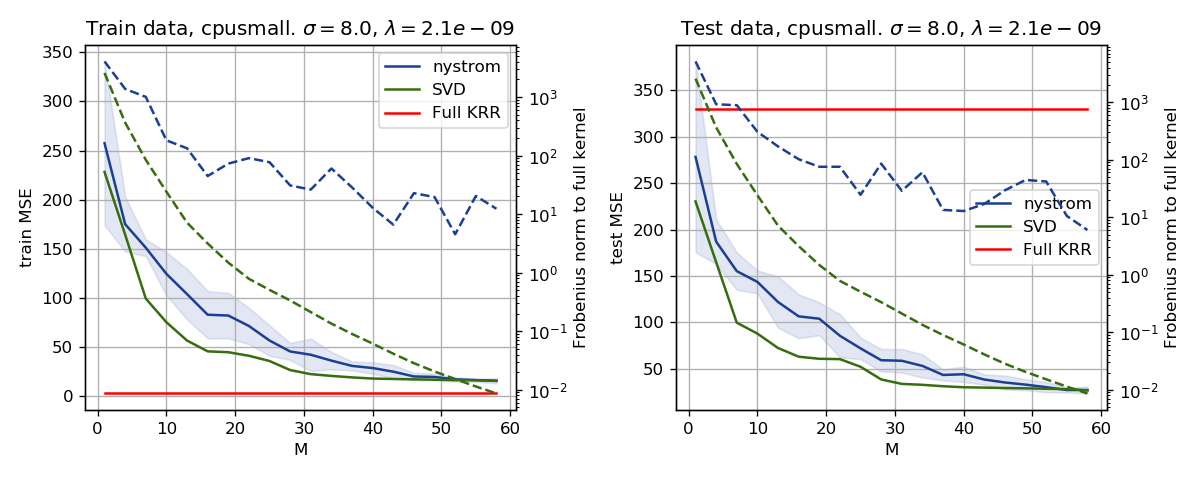

Dataset: abalone
torch.Size([4177, 8]) torch.Size([4177, 1])
1.4.7.10.13.16.19.22.25.28.31.34.37.40.43.46.49.52.55.58.1.4.7.10.13.16.19.22.25.28.31.34.37.40.43.46.49.52.55.58.

/home/giacomo/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


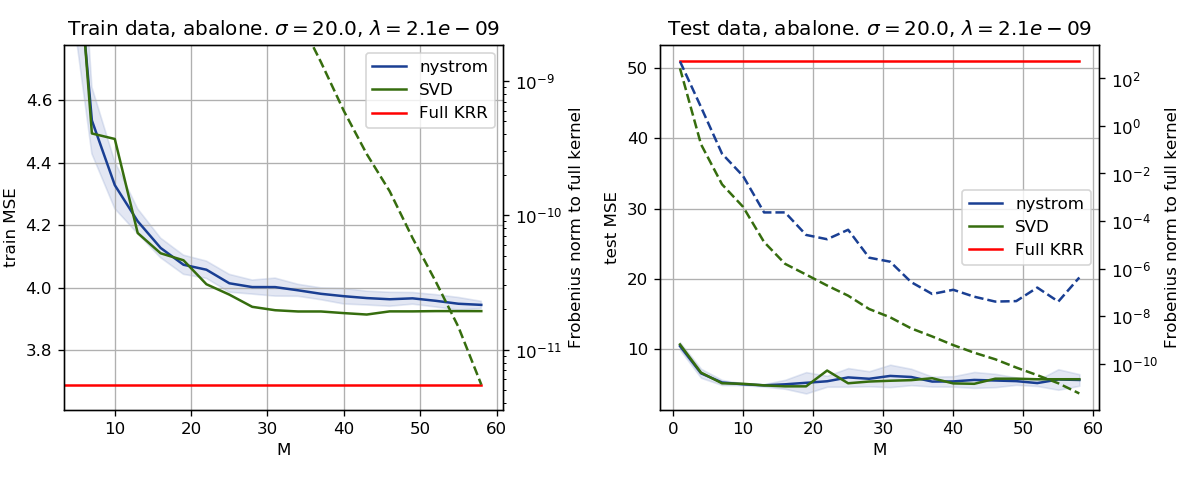

Dataset: space_ga
torch.Size([3107, 6]) torch.Size([3107, 1])
1.4.7.10.13.16.19.22.25.28.31.34.37.40.43.46.49.52.55.58.1.4.7.10.13.16.19.22.25.28.31.34.37.40.43.46.49.52.55.58.

/home/giacomo/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


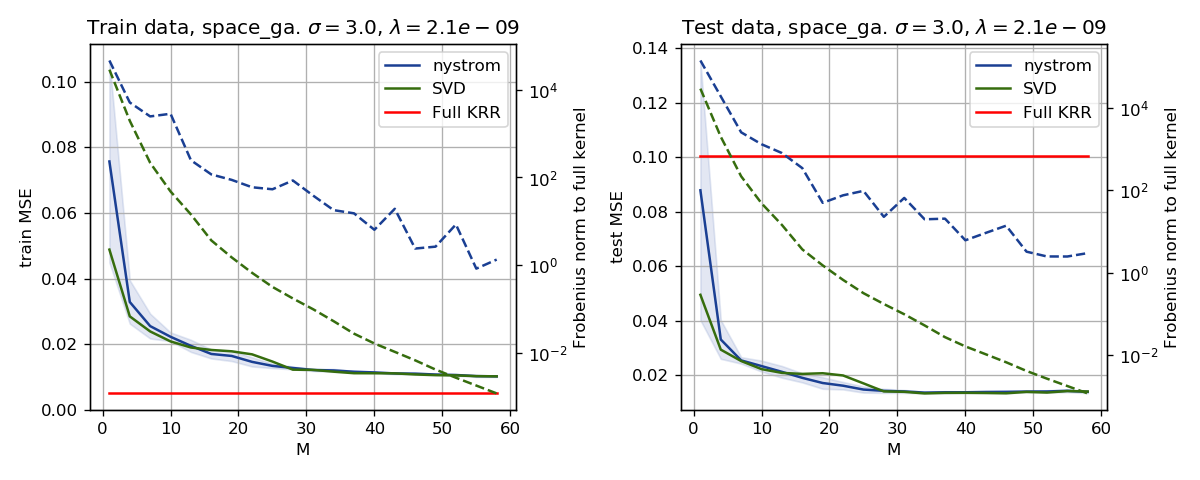

Dataset: svmguide1
torch.Size([3089, 4]) torch.Size([3089, 1])
1.4.7.10.13.16.19.22.25.28.31.34.37.40.43.46.49.52.55.58.1.4.7.10.13.16.19.22.25.28.31.34.37.40.43.46.49.52.55.58.

/home/giacomo/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


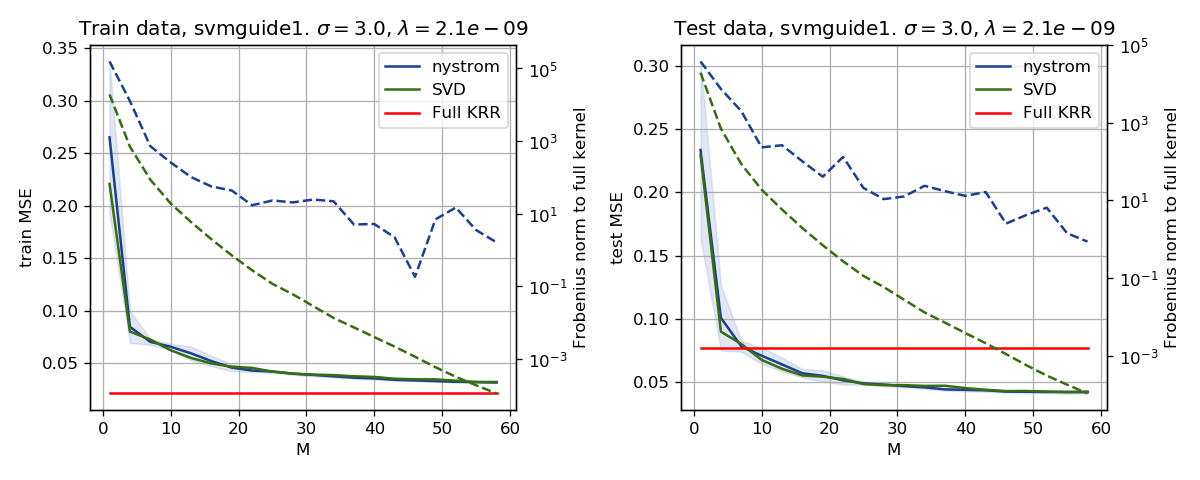

Dataset: cadata
torch.Size([20640, 8]) torch.Size([20640, 1])
1.4.7.10.13.16.19.22.25.28.31.34.37.40.43.46.49.52.55.58.1.4.7.10.13.16.19.22.25.28.31.34.37.40.43.46.49.52.55.58.

/home/giacomo/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


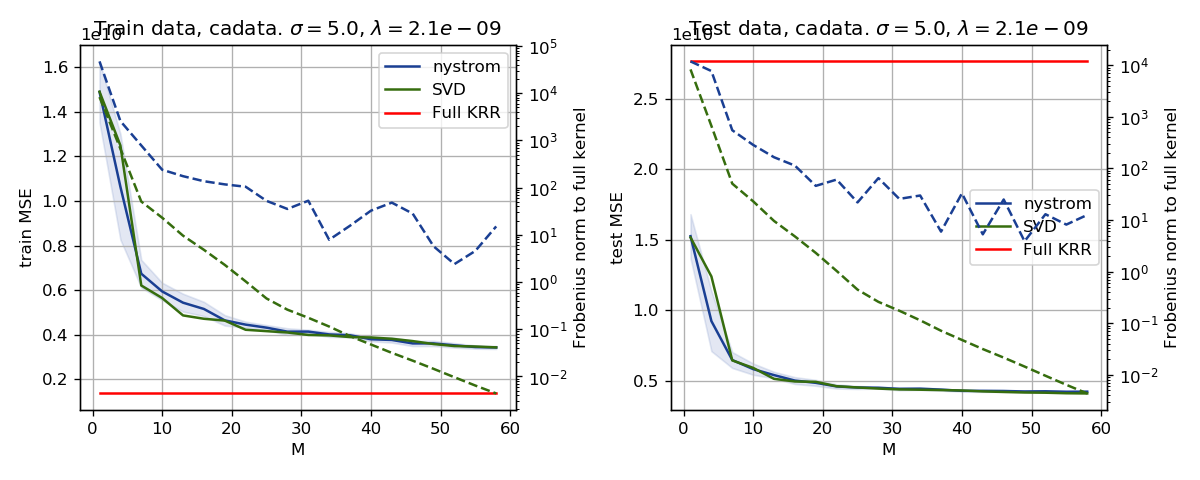

In [1680]:
for dset_name in dset_sigmas_15la.keys():
    Xtr, Ytr, Xts, Yts, penalty_init, sigma_init, kernel = load_dset(dset_name, penalty=20)
    m_list = list(range(1, 60, 3))
    train_err_data = error_evolution(m_list, 15, "train", Xtr, Xts, Ytr, Yts, kernel, torch.exp(-penalty_init))
    test_err_data = error_evolution(m_list, 15, "test", Xtr, Xts, Ytr, Yts, kernel, torch.exp(-penalty_init))
    fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
    title = "Train data, %s. $\sigma=%.1f$, $\lambda=%.1e$" % (
        dset_name, sigma_init.item(), torch.exp(-penalty_init).item())
    plot_error_evolution(m_list, train_err_data, "train", (fig, ax[0]), title)
    title = "Test data, %s. $\sigma=%.1f$, $\lambda=%.1e$" % (
        dset_name, sigma_init.item(), torch.exp(-penalty_init).item())
    plot_error_evolution(m_list, test_err_data, "test", (fig, ax[1]), title)
    fig.tight_layout()
    fig.savefig("/home/giacomo/Dropbox/unige/hyperopt/figures/%s_err_with_m_280420_v4.png" % (dset_name), dpi=400)

In [1677]:
dset_name = "svmguide1"
Xtr, Ytr, Xts, Yts, penalty_init, sigma_init, kernel = load_dset(dset_name, penalty=5)

Dataset: svmguide1
torch.Size([3089, 4]) torch.Size([3089, 1])


In [1678]:
train_err_data = error_evolution(m_list, 15, "train", Xtr, Xts, Ytr, Yts, kernel, torch.exp(-penalty_init))

1.4.7.10.13.16.19.22.25.28.31.34.37.40.43.46.49.52.55.58.

<IPython.core.display.Javascript object>


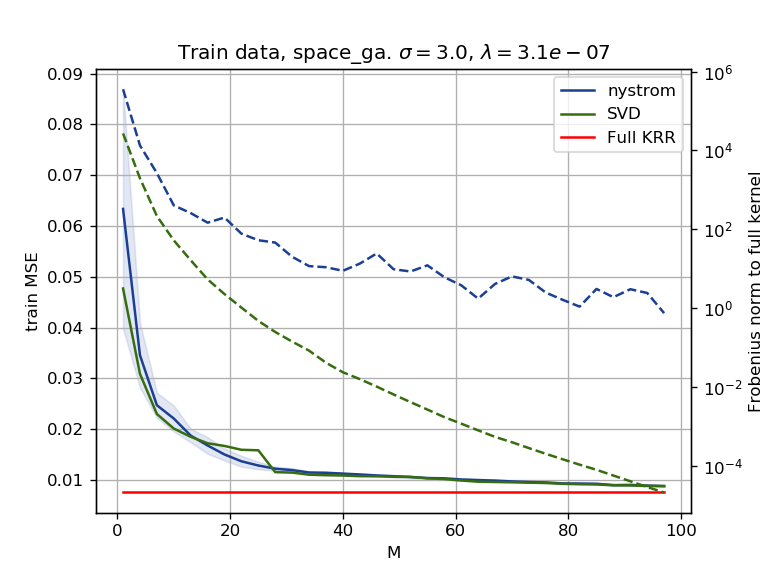

(<Figure size 640x480 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe0ef1a3290>)

In [1611]:
title = "Train data, %s. $\sigma=%.1f$, $\lambda=%.1e$" % (
    dset_name, sigma_init.item(), torch.exp(-penalty_init).item())
plot_error_evolution(m_list, train_err_data, "train", None, title)

<IPython.core.display.Javascript object>


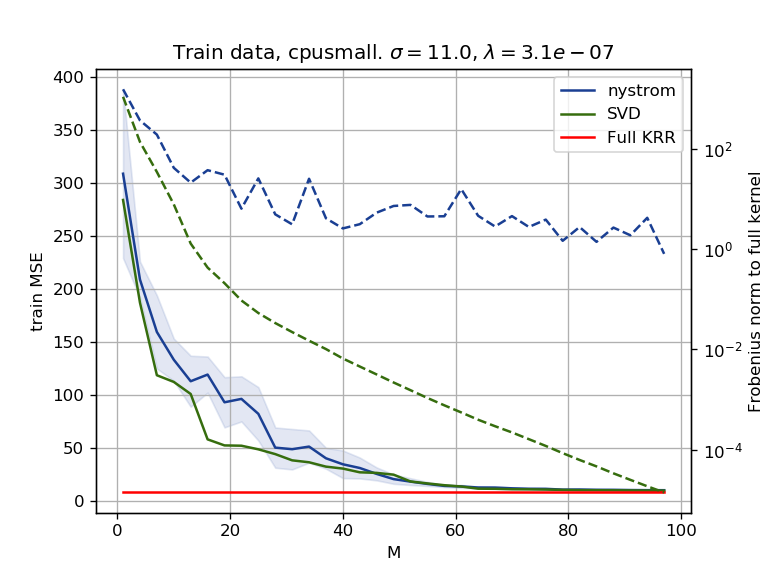

(<Figure size 640x480 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe0ef32f910>)

In [1608]:
title = "Train data, %s. $\sigma=%.1f$, $\lambda=%.1e$" % (
    dset_name, sigma_init.item(), torch.exp(-penalty_init).item())
plot_error_evolution(m_list, train_err_data, "train", None, title)

<IPython.core.display.Javascript object>


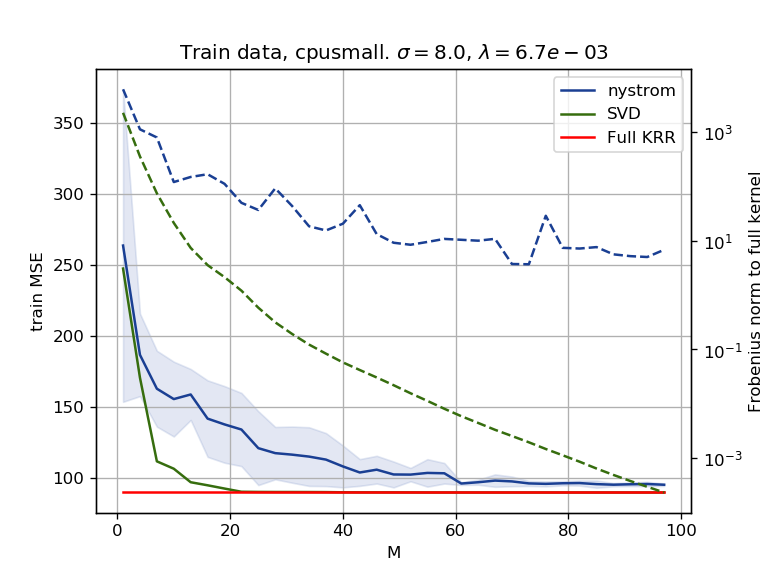

(<Figure size 640x480 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe0ef57c250>)

In [1603]:
title = "Train data, %s. $\sigma=%.1f$, $\lambda=%.1e$" % (
    dset_name, sigma_init.item(), torch.exp(-penalty_init).item())
plot_error_evolution(m_list, train_err_data, "train", None, title)

<IPython.core.display.Javascript object>


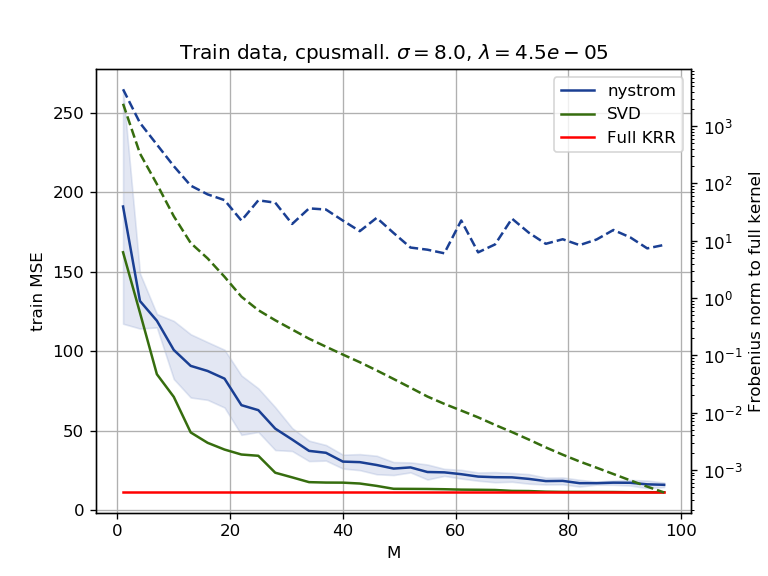

(<Figure size 640x480 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe0ef5b3790>)

In [1600]:
title = "Train data, %s. $\sigma=%.1f$, $\lambda=%.1e$" % (
    dset_name, sigma_init.item(), torch.exp(-penalty_init).item())
plot_error_evolution(m_list, train_err_data, "train", None, title)

<IPython.core.display.Javascript object>


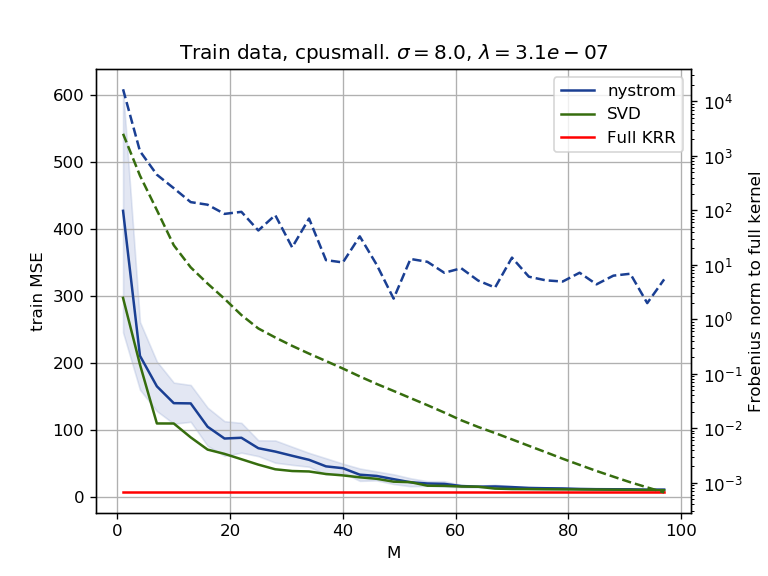

(<Figure size 640x480 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe0ef898750>)

In [1597]:
title = "Train data, %s. $\sigma=%.1f$, $\lambda=%.1e$" % (
    dset_name, sigma_init.item(), torch.exp(-penalty_init).item())
plot_error_evolution(m_list, train_err_data, "train", None, title)

In [1469]:
test_err_data = error_evolution(m_list, 15, "test", Xtr, Xts, Ytr, Yts, kernel, torch.exp(-penalty_init))

1.4.7.10.13.16.19.22.25.28.31.34.37.40.43.46.49.52.55.58.61.64.67.70.73.76.79.82.85.88.91.94.97.

<IPython.core.display.Javascript object>


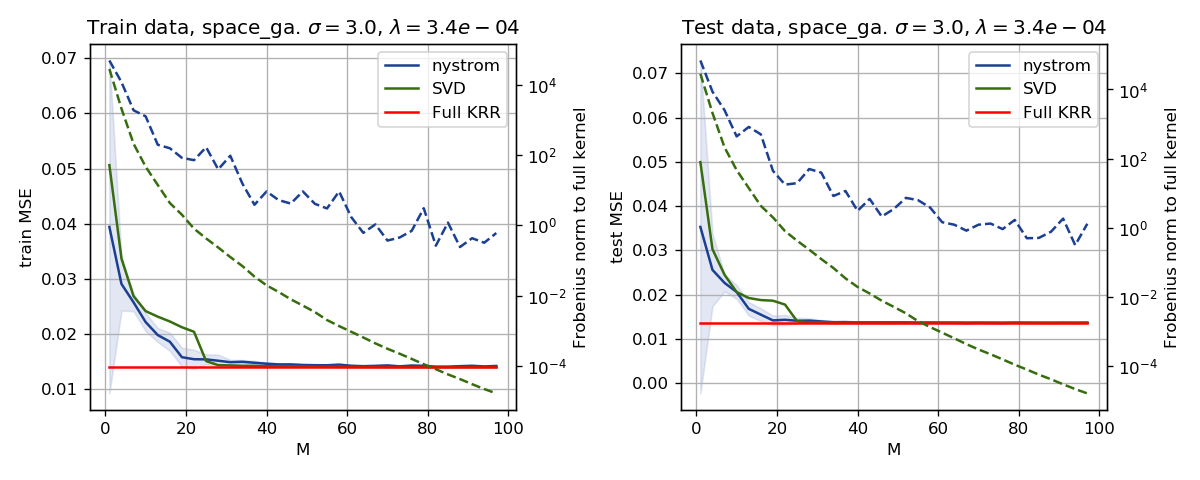

In [1476]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
title = "Train data, %s. $\sigma=%.1f$, $\lambda=%.1e$" % (
    dset_name, sigma_init.item(), torch.exp(-penalty_init).item())
plot_error_evolution(m_list, train_err_data, "train", (fig, ax[0]), title)
title = "Test data, %s. $\sigma=%.1f$, $\lambda=%.1e$" % (
    dset_name, sigma_init.item(), torch.exp(-penalty_init).item())
plot_error_evolution(m_list, test_err_data, "test", (fig, ax[1]), title)
fig.tight_layout()
fig.savefig("%s_err_with_m.png" % (dset_name), dpi=600)

<IPython.core.display.Javascript object>


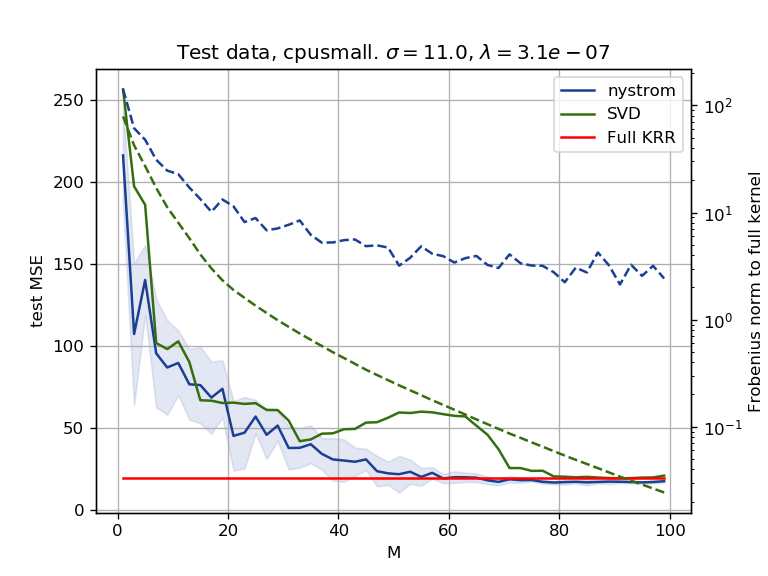

(<Figure size 640x480 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe0f522d350>)

<IPython.core.display.Javascript object>


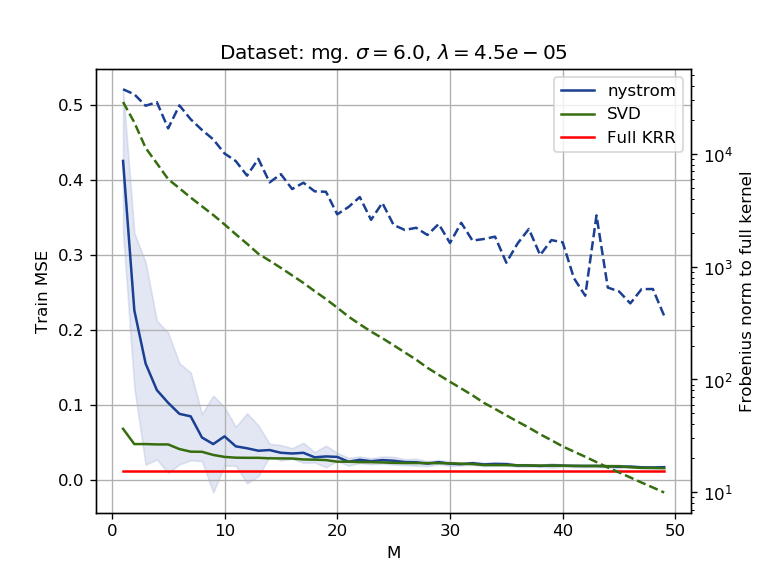

Text(0.5, 1.0, 'Dataset: mg. $\\sigma=6.0$, $\\lambda=4.5e-05$')

In [980]:
fig, ax = plt.subplots()
ax1 = ax.twinx()
# ax.plot(ms, err_random, label="random", color="#381642")
# ax.fill_between(ms, 
#                 np.asarray(err_random) - np.asarray(err_random_std), 
#                 np.asarray(err_random) + np.asarray(err_random_std),
#                 color="#7f528c", alpha=0.2)
# ax1.plot(ms, fro_random, color="#381642", linestyle="--", label="random")

ax.plot(ms, err_nystrom, label="nystrom", color="#1a3f93")
ax.fill_between(ms, 
                np.asarray(err_nystrom) - np.asarray(err_nystrom_std), 
                np.asarray(err_nystrom) + np.asarray(err_nystrom_std),
                color="#738bc4", alpha=0.2)
ax1.plot(ms, fro_nystrom, color="#1a3f93", linestyle="--", label="nystrom")

ax.plot(ms, err_svd, label="SVD", color="#366d0e")
ax1.plot(ms, fro_svd, color="#366d0e", linestyle="--", label="SVD")

ax.plot(ms, [err_krr.item()] * len(ms), color="red", label="Full KRR")

ax1.set_yscale("log")

ax.legend(loc="best")
# ax.set_ylim([150, 450])
ax.grid()

ax.set_xlabel("M")
ax.set_ylabel("Train MSE")
ax1.set_ylabel("Frobenius norm to full kernel")
ax.set_title("Dataset: %s. $\sigma=%.1f$, $\lambda=%.1e$" % (
    dset_name, sigma_init.item(), torch.exp(-penalty_init).item()))

## SGPR-like training plots

In [172]:
def train_gpflow_sgpr(penalty_init, sigma_init, centers_init, only_trace, 
                      lr, epochs, Xtr, Ytr, Xts, Yts, kernel):
    model = TrainableSGPR(sigma_init=sigma_init,
                          penalty_init=penalty_init,
                          centers_init=centers_init,
                          opt_centers=True,
                          opt_sigma=False,
                          opt_penalty=True,
                          num_epochs=epochs,
                          learning_rate=lr,
                          err_fn=mse)
    model.train(Xtr, Ytr, Xts, Yts)

def train_sgpr_like(opt_model, penalty_init, sigma_init, centers_init, only_trace, 
                    lr, epochs, Xtr, Ytr, Xts, Yts, kernel):
    if opt_model == "SGPR":
        opt_model_cls = GPComplexityReg
    elif opt_model == "Falkon":
        opt_model_cls = SimpleFalkonComplexityReg
    else: 
        raise ValueError(opt_model)
    model = opt_model_cls(
        penalty_init=penalty_init,
        sigma_init=sigma_init,
        centers_init=centers_init,
        opt_centers=True,
        opt_sigma=False,
        opt_penalty=True,
        flk_opt=falkon_opt,
        flk_maxiter=10,
        verbose_tboard=False,
        cuda=False,
        T=1,
        only_trace=only_trace,
    )
    ## Closed-form baselines
    tr_err_krr = krr_train_error(Xtr, Xts, Ytr, Yts, kernel, torch.exp(-penalty_init))
    ts_err_krr = krr_test_error(Xtr, Xts, Ytr, Yts, kernel, torch.exp(-penalty_init))
    Bnm, Gmm, Bnm_test = get_svd_bg(Xtr, M, Xts)
    tr_err_svd = get_train_error(Bnm, Bnm_test, Gmm, Ytr, Yts, torch.exp(-penalty_init))
    ts_err_svd = get_test_error(Bnm, Bnm_test, Gmm, Ytr, Yts, torch.exp(-penalty_init))
    ## Run SGD training
    train_errors, test_errors, fro_errors = [], [], []
    opt_hp = torch.optim.Adam([
        {"params": model.parameters(), "lr": lr},
    ])#, momentum=0.1)
    cum_time, cum_step = 0, 0
    for epoch in range(epochs):
        e_start = time.time()
        opt_hp.zero_grad()
        loss = -model.adapt_hps(Xtr, Ytr, cum_step)
        opt_hp.step()
        model.adapt_alpha(Xtr, Ytr)
        cum_time, train_err, test_err = test_train_predict(
            model=model, Xtr=Xtr, Ytr=Ytr, Xts=Xts, Yts=Yts,
            err_fn=mse, epoch=epoch, time_start=e_start, cum_time=cum_time)
        # Frobenius error: the squared-frobenius norm of the difference between the
        # kernel matrix with the optimized centers (Nystrom), and the kernel
        # matrix obtained by truncated-SVD of the kernel (with the same number of sing-vecs)
        fro_errors.append(compare_ker_fro(model, Xtr).item())
        train_errors.append(train_err)
        test_errors.append(test_err)
        print("Fro err: %.3f" % (fro_errors[-1]))
        cum_step += 1
        
    return {
        "tr_errs": np.asarray(train_errors), 
        "ts_errs": np.asarray(test_errors), 
        "fro_errs": np.asarray(fro_errors), 
        "tr_err_krr": tr_err_krr, 
        "ts_err_krr": ts_err_krr, 
        "tr_err_svd": tr_err_svd, 
        "ts_err_svd": ts_err_svd,
    }

In [16]:
def opt_plot(err_data, M, title, figax=None):
    if figax is None:
        fig, ax = plt.subplots()
    else:
        fig, ax = figax
    num_epochs = len(err_data["tr_errs"])
    ax.plot(range(num_epochs), err_data["tr_errs"], label="Train MSE", color="#2f2f8c", lw=2)
    ax.plot(range(num_epochs), err_data["ts_errs"], label="Test MSE", color="#c67fb7", lw=2)

    ax1 = ax.twinx()
    ax1.plot(range(num_epochs), err_data["fro_errs"], color="#3b602a", 
             linestyle="--", label="Frobenius error", lw=2)


    ax.scatter(num_epochs + 2, err_data["tr_err_krr"], label="KRR(full) train MSE", 
               s=100, marker="*", color="#2f2f8c")
    ax.scatter(num_epochs + 2, err_data["ts_err_krr"], label="KRR(full) test MSE", 
               s=100, marker="*", color="#c67fb7")

    ax.scatter(num_epochs + 7, err_data["tr_err_svd"], label="SVD(%d) train MSE" % (M), 
               s=100, marker="o", color="#2f2f8c")
    ax.scatter(num_epochs + 7, err_data["ts_err_svd"], label="SVD(%d) test MSE" % (M), 
               s=100, marker="o", color="#c67fb7")


    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax1.get_legend_handles_labels()
    ax.legend(lines + lines2, labels + labels2, loc="best")

    ax.grid()
    ax.set_xlabel("Epoch")
    ax.set_ylabel("MSE")
    ax1.set_ylabel("Frobenius Error")
    ax1.set_yscale('log')
    ax.set_title(title)
    fig.tight_layout()
    return fig, ax
def get_title(model_name, M, train_only_trace, dset_name, sigma_init=None, penalty_init=None):
    title = "%s - %s - M=%d" % (dset_name, model_name, M)
    if train_only_trace:
        title += " - TRACE optimized"
    if sigma_init is not None:
        title += " - $\sigma=%.1f$" % (sigma_init.item())
    if penalty_init is not None:
        title += " - $\lambda=%.2e$" % (penalty_init.item())
    return title

In [54]:
M = 100
train_only_trace = True
learning_rate = 0.1
only_trace_100 = {}
for dset_name in ["cpusmall", "space_ga"]:
    Xtr, Ytr, Xts, Yts, penalty_init, sigma_init, kernel = load_dset(dset_name, penalty=15)
    centers_init = torch.randn(M, Xtr.shape[1], dtype=Xtr.dtype)
    res_flk = train_sgpr_like(opt_model="Falkon", penalty_init=penalty_init, sigma_init=sigma_init, 
                              centers_init=centers_init, only_trace=train_only_trace, lr=learning_rate, 
                              epochs=num_epochs, Xtr=Xtr, Ytr=Ytr, Xts=Xts, Yts=Yts, kernel=kernel)
    only_trace_100[dset_name] = res_flk

Dataset: cpusmall
torch.Size([8192, 12]) torch.Size([8192, 1])
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -2.00240e+04
Epoch 0 ( 2.69s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 215.3927 - Ts  mse = 489.9392
Fro err: 10.344
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -1.70992e+04
Epoch 1 ( 5.74s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 128.5841 - Ts  mse = 402.5931
Fro err: 9.132
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -1.56763e+04
Epoch 2 ( 8.65s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 98.9849 - Ts  mse = 333.7506
Fro err: 8.325
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -1.47039e+04
Epoch 3 (11.06s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 78.1040 - Ts  mse = 281.5144
Fro err: 7.642
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -1.39037e+04
Epoch 4 (13.50s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 62.1906 - Ts  mse = 243.5924
Fro err: 7.008
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00

Epoch 46 (103.23s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 10.3763 - Ts  mse = 26.4244
Fro err: 0.553
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -2.96846e+03
Epoch 47 (105.25s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 10.3297 - Ts  mse = 25.9322
Fro err: 0.556
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -2.95578e+03
Epoch 48 (106.98s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 10.3271 - Ts  mse = 25.9280
Fro err: 0.475
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -2.79775e+03
Epoch 49 (108.52s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 10.2608 - Ts  mse = 25.4456
Fro err: 0.475
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -2.77372e+03
Epoch 50 (110.14s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 10.1291 - Ts  mse = 24.9153
Fro err: 0.448
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -2.69847e+03
Epoch 51 (111.69s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 10.0160 - Ts  mse = 24.3983
Fro err: 0.413
VAL

Fro err: 0.040
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -1.10780e+03
Epoch 93 (168.35s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 9.5143 - Ts  mse = 31.2610
Fro err: 0.040
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -1.09753e+03
Epoch 94 (169.74s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 9.6337 - Ts  mse = 31.4951
Fro err: 0.042
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -1.09886e+03
Epoch 95 (170.97s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 9.5683 - Ts  mse = 31.0921
Fro err: 0.032
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -1.04443e+03
Epoch 96 (172.19s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 9.6062 - Ts  mse = 33.9447
Fro err: 0.034
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -1.04674e+03
Epoch 97 (173.27s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 9.7930 - Ts  mse = 32.2067
Fro err: 0.037
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -1.04800e+03
Epoch 98 (174.32s) - Sigma 8.

Epoch 39 (52.99s) - Sigma 3.000 - Penalty 3.06e-07 - Tr  mse = 0.0093 - Ts  mse = 0.0126
Fro err: 0.004
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -5.07570e+02
Epoch 40 (54.07s) - Sigma 3.000 - Penalty 3.06e-07 - Tr  mse = 0.0093 - Ts  mse = 0.0127
Fro err: 0.003
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -4.88993e+02
Epoch 41 (55.22s) - Sigma 3.000 - Penalty 3.06e-07 - Tr  mse = 0.0093 - Ts  mse = 0.0127
Fro err: 0.003
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -4.70479e+02
Epoch 42 (56.40s) - Sigma 3.000 - Penalty 3.06e-07 - Tr  mse = 0.0092 - Ts  mse = 0.0127
Fro err: 0.003
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -4.51545e+02
Epoch 43 (57.45s) - Sigma 3.000 - Penalty 3.06e-07 - Tr  mse = 0.0092 - Ts  mse = 0.0129
Fro err: 0.003
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -4.34507e+02
Epoch 44 (58.47s) - Sigma 3.000 - Penalty 3.06e-07 - Tr  mse = 0.0092 - Ts  mse = 0.0129
Fro err: 0.002
VALUE        d_eff 0.

Epoch 86 (112.90s) - Sigma 3.000 - Penalty 3.06e-07 - Tr  mse = 0.0088 - Ts  mse = 0.0120
Fro err: 0.000
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -1.84105e+02
Epoch 87 (114.22s) - Sigma 3.000 - Penalty 3.06e-07 - Tr  mse = 0.0088 - Ts  mse = 0.0120
Fro err: 0.000
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -1.82407e+02
Epoch 88 (115.77s) - Sigma 3.000 - Penalty 3.06e-07 - Tr  mse = 0.0088 - Ts  mse = 0.0119
Fro err: 0.000
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -1.80739e+02
Epoch 89 (116.78s) - Sigma 3.000 - Penalty 3.06e-07 - Tr  mse = 0.0088 - Ts  mse = 0.0119
Fro err: 0.000
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -1.79172e+02
Epoch 90 (117.95s) - Sigma 3.000 - Penalty 3.06e-07 - Tr  mse = 0.0088 - Ts  mse = 0.0120
Fro err: 0.000
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -1.77684e+02
Epoch 91 (119.30s) - Sigma 3.000 - Penalty 3.06e-07 - Tr  mse = 0.0088 - Ts  mse = 0.0120
Fro err: 0.000
VALUE        d_

<IPython.core.display.Javascript object>


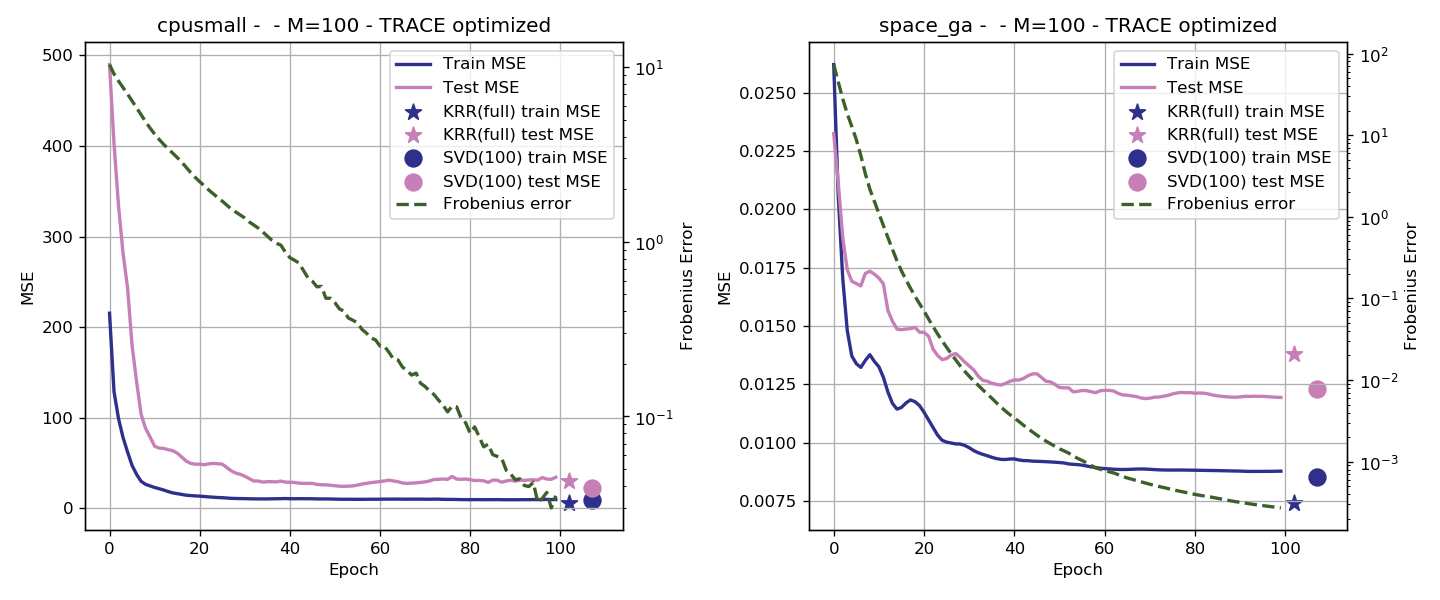

In [56]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 5))
for i, (dset_name, data) in enumerate(only_trace_100.items()):
    title = get_title("", 100, True, dset_name)
    opt_plot(data, 100, title, figax=(fig, ax[i]))

In [ ]:
M = 100
train_only_trace = False
learning_rate = 0.1
num_epochs = 100
results_100_flk = {}
results_100_sgpr = {}
for dset_name in ["cpusmall", "space_ga"]:
    Xtr, Ytr, Xts, Yts, penalty_init, sigma_init, kernel = load_dset(dset_name, penalty=15)
    centers_init = torch.randn(M, Xtr.shape[1], dtype=Xtr.dtype)
    res_flk = train_sgpr_like(opt_model="Falkon", penalty_init=penalty_init, sigma_init=sigma_init,
                              centers_init=centers_init, only_trace=train_only_trace, lr=learning_rate,
                              epochs=num_epochs, Xtr=Xtr, Ytr=Ytr, Xts=Xts, Yts=Yts, kernel=kernel)
    res_sgpr = train_sgpr_like(opt_model="SGPR", penalty_init=penalty_init, sigma_init=sigma_init,
                               centers_init=centers_init, only_trace=train_only_trace, lr=learning_rate,
                               epochs=num_epochs, Xtr=Xtr, Ytr=Ytr, Xts=Xts, Yts=Yts, kernel=kernel)
    results_100_flk[dset_name] = res_flk
    results_100_sgpr[dset_name]= res_sgpr

Dataset: cpusmall
torch.Size([8192, 12]) torch.Size([8192, 1])
VALUE        d_eff -3.01089e+05 - loss -3.96653e+07 - trace -2.07880e+04
Epoch 0 ( 1.56s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 213.8287 - Ts  mse = 501.5016
Fro err: 16.146
VALUE        d_eff -3.01827e+05 - loss -3.58626e+07 - trace -2.07464e+04
Epoch 1 ( 3.24s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 116.4996 - Ts  mse = 296.7578
Fro err: 16.272
VALUE        d_eff -3.01965e+05 - loss -3.42083e+07 - trace -2.09134e+04
Epoch 2 ( 4.56s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 80.9815 - Ts  mse = 255.2180
Fro err: 15.951
VALUE        d_eff -3.02031e+05 - loss -3.28677e+07 - trace -2.08092e+04
Epoch 3 ( 5.64s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 59.4460 - Ts  mse = 215.4174
Fro err: 15.713
VALUE        d_eff -3.02230e+05 - loss -3.12838e+07 - trace -2.07726e+04
Epoch 4 ( 6.81s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 45.9063 - Ts  mse = 179.1606
Fro err: 15.606
VALUE        d_eff -3.02588e+05 - l

Epoch 45 (60.64s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 7.8574 - Ts  mse = 26.0746
Fro err: 11.573
VALUE        d_eff -3.04616e+05 - loss -2.37450e+07 - trace -1.89789e+04
Epoch 46 (61.78s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 7.8698 - Ts  mse = 26.0093
Fro err: 11.500
VALUE        d_eff -3.04706e+05 - loss -2.37022e+07 - trace -1.89201e+04
Epoch 47 (63.08s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 7.7559 - Ts  mse = 25.6326
Fro err: 11.452
VALUE        d_eff -3.04838e+05 - loss -2.35617e+07 - trace -1.88697e+04
Epoch 48 (64.61s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 7.6723 - Ts  mse = 25.2841
Fro err: 11.411
VALUE        d_eff -3.04943e+05 - loss -2.35977e+07 - trace -1.88242e+04
Epoch 49 (66.12s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 7.6059 - Ts  mse = 25.1409
Fro err: 11.353
VALUE        d_eff -3.05073e+05 - loss -2.35150e+07 - trace -1.87686e+04
Epoch 50 (67.78s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 7.5746 - Ts  mse = 25.0093
Fro err: 11.291

Epoch 91 (127.36s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 6.6321 - Ts  mse = 22.6281
Fro err: 9.704
VALUE        d_eff -3.07439e+05 - loss -2.31354e+07 - trace -1.71191e+04
Epoch 92 (128.72s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 6.6818 - Ts  mse = 22.9891
Fro err: 9.694
VALUE        d_eff -3.07410e+05 - loss -2.31623e+07 - trace -1.70860e+04
Epoch 93 (129.95s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 6.6266 - Ts  mse = 22.2976
Fro err: 9.616
VALUE        d_eff -3.07520e+05 - loss -2.30987e+07 - trace -1.70295e+04
Epoch 94 (131.27s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 6.6143 - Ts  mse = 22.7475
Fro err: 9.588
VALUE        d_eff -3.07591e+05 - loss -2.30441e+07 - trace -1.69944e+04
Epoch 95 (133.37s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 6.6020 - Ts  mse = 22.5569
Fro err: 9.573
VALUE        d_eff -3.07550e+05 - loss -2.30950e+07 - trace -1.69670e+04
Epoch 96 (136.15s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 6.5936 - Ts  mse = 22.6591
Fro err: 9.534

Epoch 37 (49.91s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 8.4988 - Ts  mse = 28.6569
Fro err: 11.981
VALUE        d_eff 3.80652e+03 - loss -1.19234e+07 - trace -1.93677e+04
Epoch 38 (50.99s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 8.3535 - Ts  mse = 28.4853
Fro err: 11.952
VALUE        d_eff 3.80652e+03 - loss -1.19067e+07 - trace -1.93477e+04
Epoch 39 (52.02s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 8.2681 - Ts  mse = 27.7571
Fro err: 11.920
VALUE        d_eff 3.80650e+03 - loss -1.18896e+07 - trace -1.93219e+04
Epoch 40 (53.06s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 8.1675 - Ts  mse = 27.4143
Fro err: 11.884
VALUE        d_eff 3.80648e+03 - loss -1.18729e+07 - trace -1.92932e+04
Epoch 41 (54.09s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 8.1183 - Ts  mse = 27.2007
Fro err: 11.852
VALUE        d_eff 3.80647e+03 - loss -1.18599e+07 - trace -1.92683e+04
Epoch 42 (55.30s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 8.0487 - Ts  mse = 26.6539
Fro err: 11.818
VALU

Epoch 83 (119.87s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 6.6626 - Ts  mse = 23.0653
Fro err: 9.976
VALUE        d_eff 3.80318e+03 - loss -1.15541e+07 - trace -1.74371e+04
Epoch 84 (121.04s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 6.6776 - Ts  mse = 22.7186
Fro err: 9.940
VALUE        d_eff 3.80310e+03 - loss -1.15773e+07 - trace -1.73975e+04
Epoch 85 (122.13s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 6.7971 - Ts  mse = 23.2726
Fro err: 9.897
VALUE        d_eff 3.80304e+03 - loss -1.16271e+07 - trace -1.73555e+04
Epoch 86 (123.32s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 6.7982 - Ts  mse = 22.6608
Fro err: 9.862
VALUE        d_eff 3.80288e+03 - loss -1.16465e+07 - trace -1.73106e+04
Epoch 87 (124.55s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 6.6940 - Ts  mse = 22.6664
Fro err: 9.823
VALUE        d_eff 3.80279e+03 - loss -1.15367e+07 - trace -1.72750e+04
Epoch 88 (125.73s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 6.7867 - Ts  mse = 23.2557
Fro err: 9.802
VALU

<IPython.core.display.Javascript object>


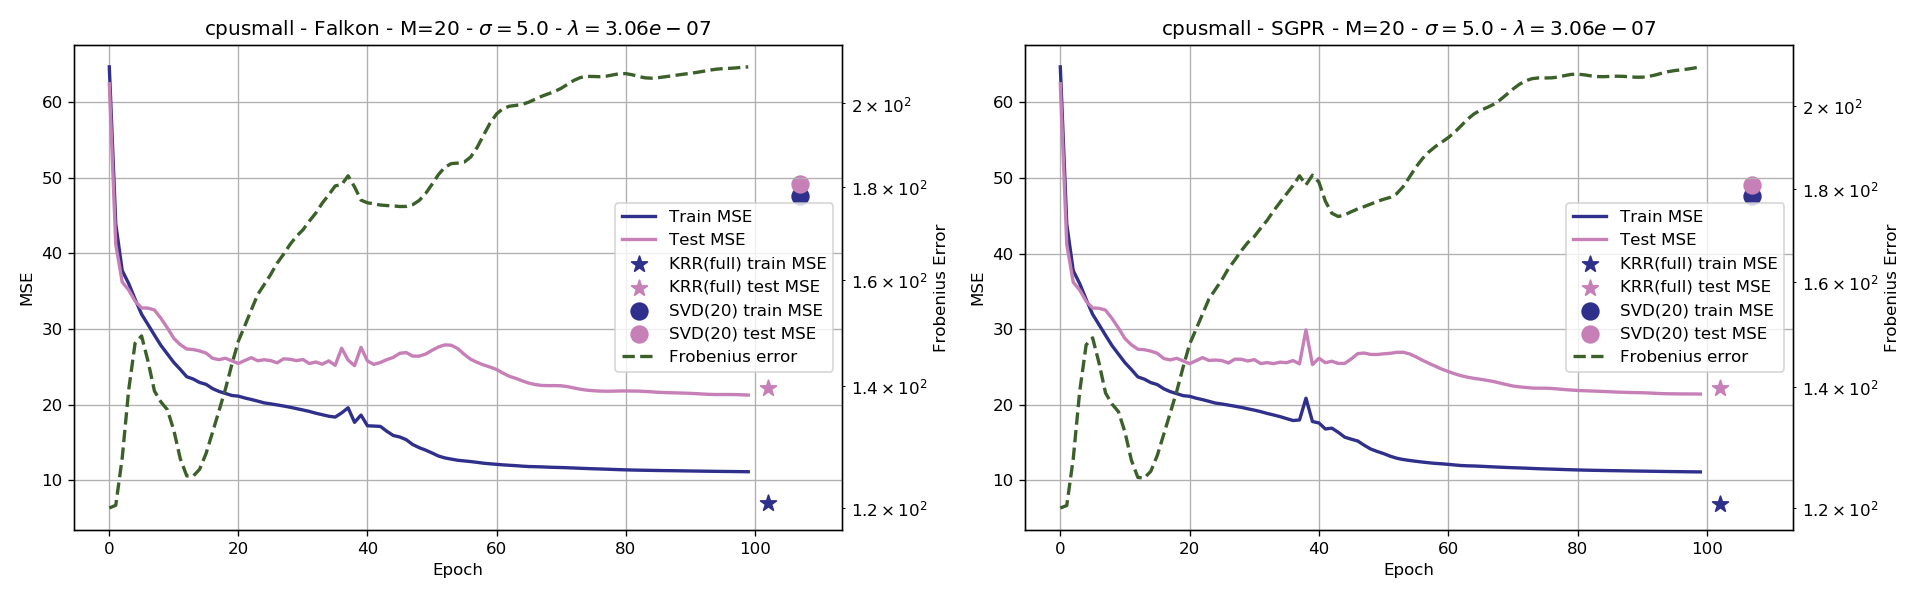

<IPython.core.display.Javascript object>


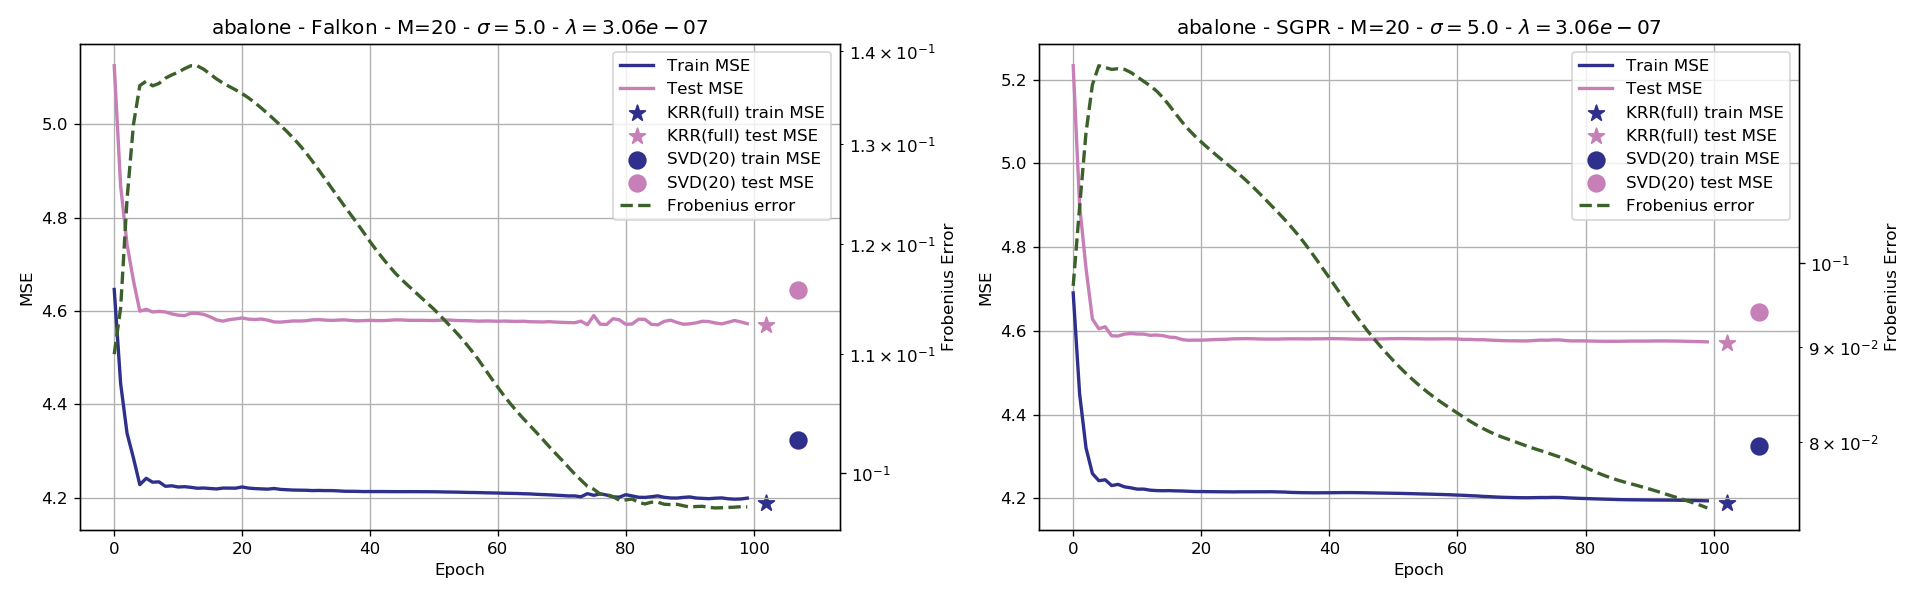

<IPython.core.display.Javascript object>


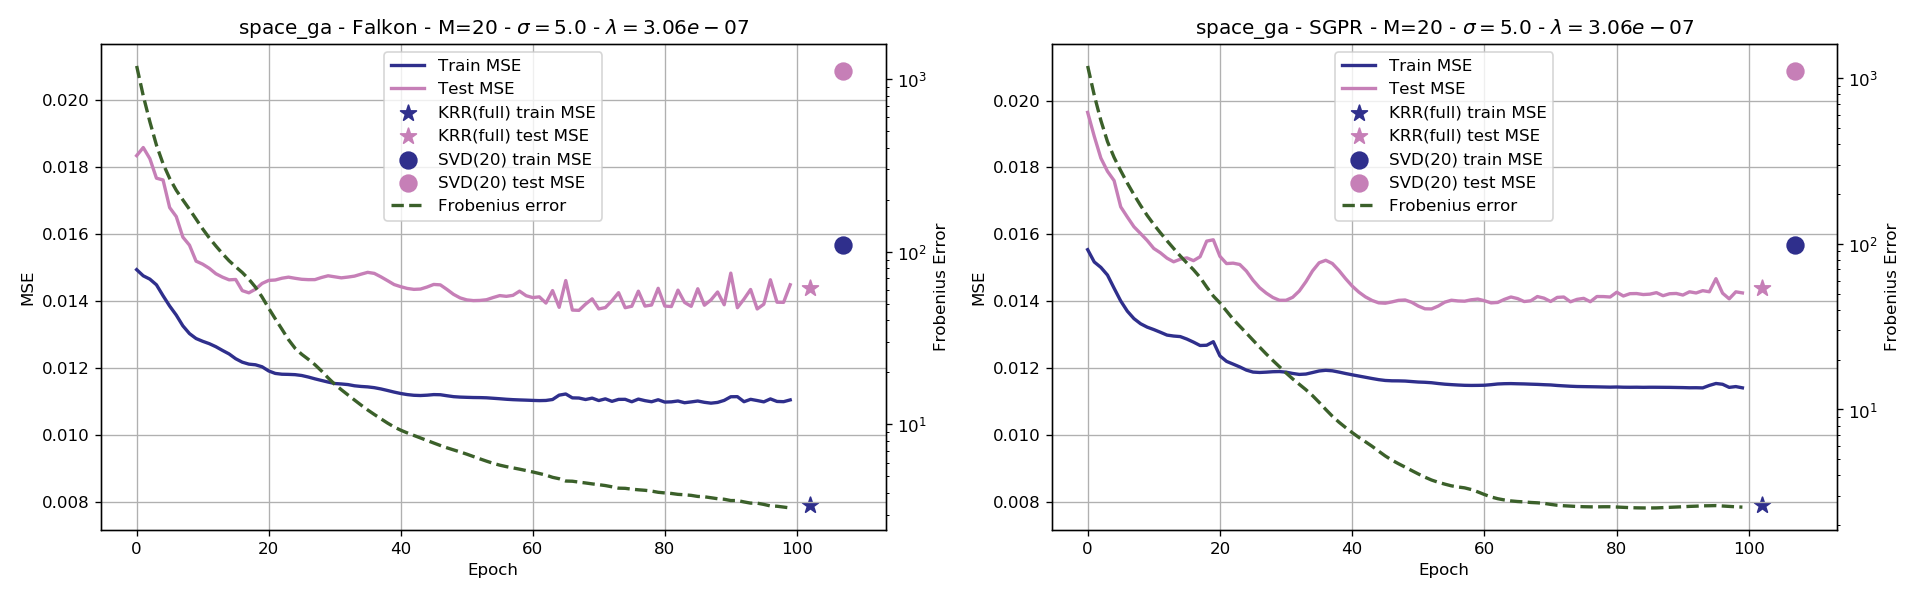

<IPython.core.display.Javascript object>


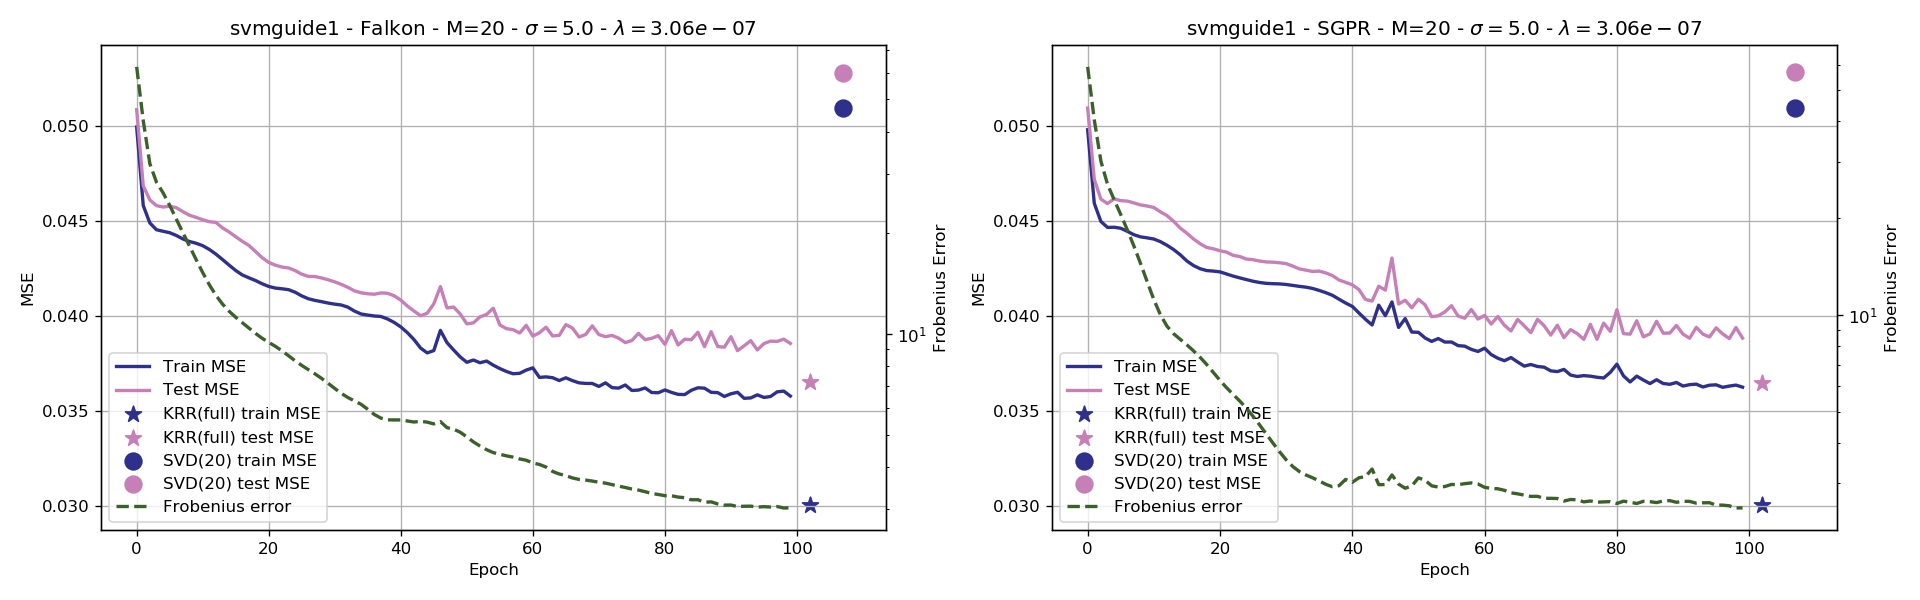

<IPython.core.display.Javascript object>


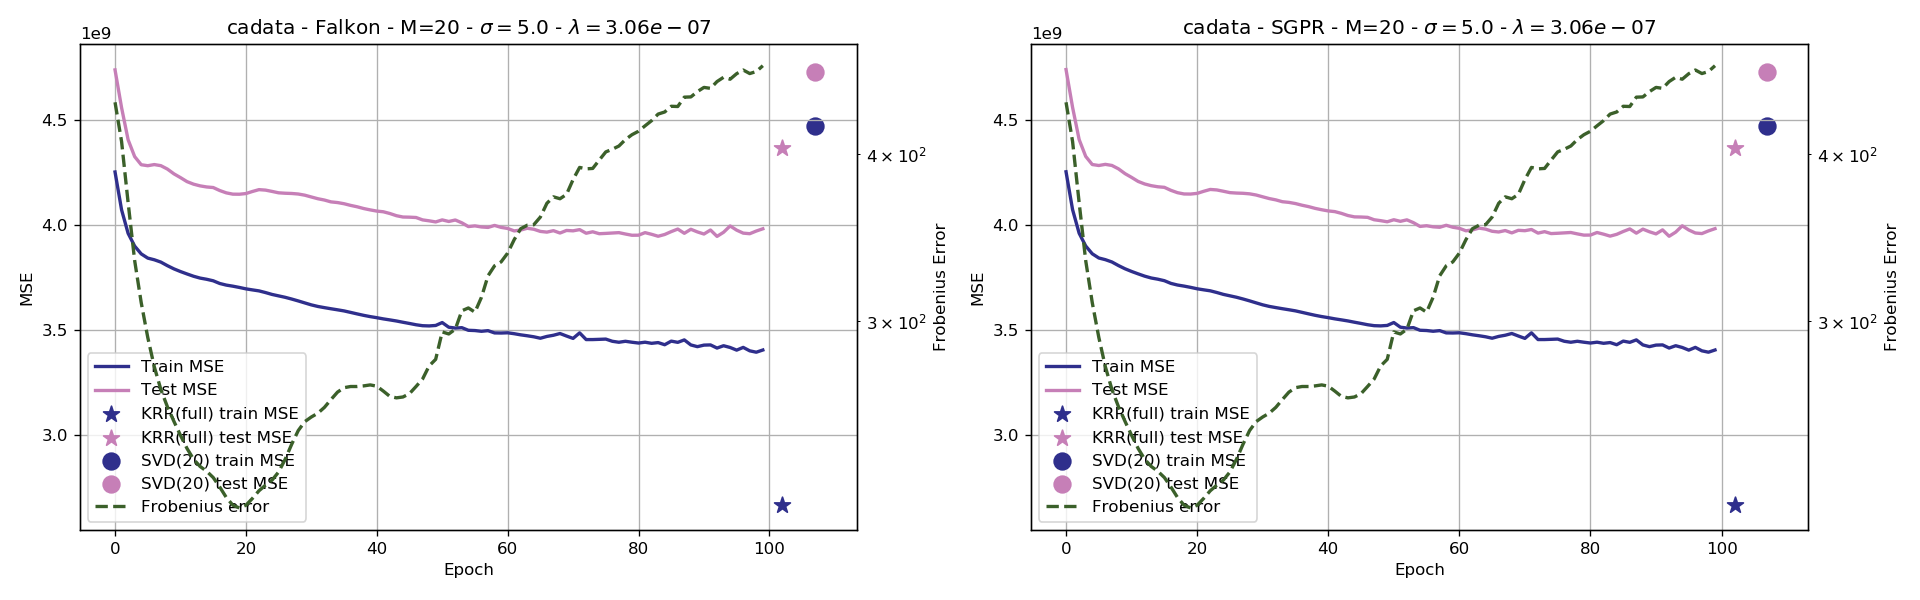

In [50]:
for dset_name in dset_sigmas_15la.keys():
    fig, ax = plt.subplots(ncols=2, figsize=(16, 5))
    title = get_title("Falkon", 20, False, dset_name, sigma_init=sigma_init, penalty_init=torch.exp(-penalty_init))
    opt_plot(results_20_flk[dset_name], 20, title, figax=(fig, ax[0]))
    title = get_title("SGPR", 20, False, dset_name, sigma_init=sigma_init, penalty_init=torch.exp(-penalty_init))
    opt_plot(results_20_sgpr[dset_name], 20, title, figax=(fig, ax[1]))
    fig.tight_layout()
    fig.savefig("figures/opt_290420_M20_%s_v1.png" % (dset_name))

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
title = get_title("Falkon", M, train_only_trace, dset_name)
opt_plot(res_flk, M, title, figax=(fig, ax[0]))
title = get_title("SGPR", M, train_only_trace, dset_name)
opt_plot(res_sgpr, M, title, figax=(fig, ax[1]))
fig.tight_layout();

In [179]:
dset_name = "svmguide1"
Xtr, Ytr, Xts, Yts, penalty_init, sigma_init, kernel = load_dset(dset_name, penalty=1, dtype=torch.float64)
print(Xtr.dtype)
M = 5
torch.manual_seed(82)
centers_init = torch.randn(M, Xtr.shape[1], dtype=Xtr.dtype)
learning_rate = 0.1
num_epochs = 75
train_only_trace = False

Dataset: svmguide1
torch.Size([3089, 4]) torch.Size([3089, 1])
torch.float64


In [183]:
res_sgpr = train_gpflow_sgpr(
    penalty_init=penalty_init, sigma_init=sigma_init, 
    centers_init=centers_init, only_trace=train_only_trace, lr=learning_rate, 
    epochs=num_epochs, Xtr=Xtr, Ytr=Ytr, Xts=Xts, Yts=Yts, kernel=kernel)

╒══════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════════════════════════════════════╕
│ name                     │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                                      │
╞══════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════════════════════════════════════╡
│ SGPR.kernel.variance     │ Parameter │ Softplus         │         │ False       │ ()      │ float64 │ 1.0                                        │
├──────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────────────────────────────┤
│ SGPR.kernel.lengthscales │ Parameter │ Softplus         │         │ False       │ ()      │ float64 │ 3.0                                        │
├──────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───

In [154]:
res_sgpr = train_sgpr_like(opt_model="SGPR", penalty_init=penalty_init, sigma_init=sigma_init, 
                           centers_init=centers_init, only_trace=train_only_trace, lr=learning_rate, 
                           epochs=num_epochs, Xtr=Xtr, Ytr=Ytr, Xts=Xts, Yts=Yts, kernel=kernel)

-logdet: -3.0e+03
VALUE        d_eff -2.955e+03 - loss -4.719e-01 - trace -1.021e-01. tot -2.955e+03
Epoch 0 ( 0.48s) - Sigma 3.000 - Penalty 3.33e-01 - Tr  mse = 0.2157 - Ts  mse = 0.2132
Fro err: 783.665
-logdet: -2.9e+03
VALUE        d_eff -2.905e+03 - loss -5.016e-01 - trace -9.792e-02. tot -2.905e+03
Epoch 1 ( 0.97s) - Sigma 3.000 - Penalty 3.01e-01 - Tr  mse = 0.2051 - Ts  mse = 0.2026
Fro err: 642.540
-logdet: -2.9e+03
VALUE        d_eff -2.855e+03 - loss -5.335e-01 - trace -9.788e-02. tot -2.855e+03
Epoch 2 ( 1.45s) - Sigma 3.000 - Penalty 2.73e-01 - Tr  mse = 0.1956 - Ts  mse = 0.1931
Fro err: 542.834
-logdet: -2.8e+03
VALUE        d_eff -2.805e+03 - loss -5.677e-01 - trace -9.985e-02. tot -2.806e+03
Epoch 3 ( 1.93s) - Sigma 3.000 - Penalty 2.47e-01 - Tr  mse = 0.1869 - Ts  mse = 0.1843
Fro err: 450.632
-logdet: -2.8e+03
VALUE        d_eff -2.755e+03 - loss -6.041e-01 - trace -1.020e-01. tot -2.756e+03
Epoch 4 ( 2.41s) - Sigma 3.000 - Penalty 2.23e-01 - Tr  mse = 0.1787 - Ts  

Fro err: 18.842
-logdet: -9.6e+02
VALUE        d_eff -9.647e+02 - loss -6.639e+00 - trace -1.478e+00. tot -9.728e+02
Epoch 40 (19.86s) - Sigma 3.000 - Penalty 6.13e-03 - Tr  mse = 0.0701 - Ts  mse = 0.0628
Fro err: 18.682
-logdet: -9.2e+02
VALUE        d_eff -9.153e+02 - loss -7.179e+00 - trace -1.638e+00. tot -9.241e+02
Epoch 41 (20.34s) - Sigma 3.000 - Penalty 5.55e-03 - Tr  mse = 0.0692 - Ts  mse = 0.0619
Fro err: 18.296
-logdet: -8.7e+02
VALUE        d_eff -8.659e+02 - loss -7.769e+00 - trace -1.810e+00. tot -8.755e+02
Epoch 42 (20.83s) - Sigma 3.000 - Penalty 5.03e-03 - Tr  mse = 0.0683 - Ts  mse = 0.0610
Fro err: 18.159
-logdet: -8.2e+02
VALUE        d_eff -8.166e+02 - loss -8.414e+00 - trace -1.997e+00. tot -8.270e+02
Epoch 43 (21.31s) - Sigma 3.000 - Penalty 4.55e-03 - Tr  mse = 0.0673 - Ts  mse = 0.0602
Fro err: 18.373
-logdet: -7.7e+02
VALUE        d_eff -7.673e+02 - loss -9.112e+00 - trace -2.206e+00. tot -7.787e+02
Epoch 44 (21.79s) - Sigma 3.000 - Penalty 4.12e-03 - Tr  ms

KeyboardInterrupt: 

In [170]:
res_flk = train_sgpr_like(opt_model="Falkon", penalty_init=penalty_init, sigma_init=sigma_init,
                          centers_init=centers_init, only_trace=train_only_trace, lr=learning_rate*2,
                          epochs=num_epochs, Xtr=Xtr, Ytr=Ytr, Xts=Xts, Yts=Yts, kernel=kernel)

VALUE        d_eff -3.850e+02 - loss -9.676e-01 - trace -1.769e-01. tot -3.861e+02
Epoch 0 ( 0.68s) - Sigma 3.000 - Penalty 3.01e-01 - Tr  mse = 0.2370 - Ts  mse = 0.2330
Fro err: 7678.062
VALUE        d_eff -3.276e+02 - loss -1.151e+00 - trace -2.738e-01. tot -3.291e+02
Epoch 1 ( 1.36s) - Sigma 3.000 - Penalty 2.47e-01 - Tr  mse = 0.2362 - Ts  mse = 0.2349
Fro err: 10946.221
VALUE        d_eff -2.750e+02 - loss -1.354e+00 - trace -3.982e-01. tot -2.767e+02
Epoch 2 ( 2.04s) - Sigma 3.000 - Penalty 2.02e-01 - Tr  mse = 0.2211 - Ts  mse = 0.2227
Fro err: 11112.687
VALUE        d_eff -2.406e+02 - loss -1.543e+00 - trace -5.039e-01. tot -2.426e+02
Epoch 3 ( 2.72s) - Sigma 3.000 - Penalty 1.66e-01 - Tr  mse = 0.2249 - Ts  mse = 0.2281
Fro err: 12669.263
VALUE        d_eff -2.089e+02 - loss -1.827e+00 - trace -6.446e-01. tot -2.114e+02
Epoch 4 ( 3.40s) - Sigma 3.000 - Penalty 1.37e-01 - Tr  mse = 0.2239 - Ts  mse = 0.2287
Fro err: 14107.294
VALUE        d_eff -1.820e+02 - loss -2.150e+00 - t

Epoch 43 (30.18s) - Sigma 3.000 - Penalty 1.08e-02 - Tr  mse = 0.0872 - Ts  mse = 0.1001
Fro err: 30014.676
VALUE        d_eff -2.512e+01 - loss -1.028e+01 - trace -1.489e+01. tot -5.029e+01
Epoch 44 (30.85s) - Sigma 3.000 - Penalty 1.10e-02 - Tr  mse = 0.0865 - Ts  mse = 0.0993
Fro err: 28168.670
VALUE        d_eff -2.536e+01 - loss -1.015e+01 - trace -1.439e+01. tot -4.990e+01
Epoch 45 (31.53s) - Sigma 3.000 - Penalty 1.11e-02 - Tr  mse = 0.0861 - Ts  mse = 0.0988
Fro err: 26348.281
VALUE        d_eff -2.557e+01 - loss -1.004e+01 - trace -1.391e+01. tot -4.953e+01
Epoch 46 (32.20s) - Sigma 3.000 - Penalty 1.13e-02 - Tr  mse = 0.0858 - Ts  mse = 0.0985
Fro err: 24612.594
VALUE        d_eff -2.577e+01 - loss -9.970e+00 - trace -1.347e+01. tot -4.921e+01
Epoch 47 (32.88s) - Sigma 3.000 - Penalty 1.14e-02 - Tr  mse = 0.0857 - Ts  mse = 0.0984
Fro err: 23005.805
VALUE        d_eff -2.594e+01 - loss -9.925e+00 - trace -1.306e+01. tot -4.893e+01
Epoch 48 (33.56s) - Sigma 3.000 - Penalty 1.1

In [158]:
res_flk = train_sgpr_like(opt_model="Falkon", penalty_init=penalty_init, sigma_init=sigma_init,
                          centers_init=centers_init, only_trace=train_only_trace, lr=learning_rate*6,
                          epochs=num_epochs, Xtr=Xtr, Ytr=Ytr, Xts=Xts, Yts=Yts, kernel=kernel)

VALUE        d_eff -3.850e+02 - loss -9.676e-01 - trace -1.769e-01. tot -3.861e+02
Epoch 0 ( 0.48s) - Sigma 3.000 - Penalty 2.02e-01 - Tr  mse = 0.2143 - Ts  mse = 0.2155
Fro err: 10256.528
VALUE        d_eff -2.508e+02 - loss -1.535e+00 - trace -4.952e-01. tot -2.528e+02
Epoch 1 ( 0.97s) - Sigma 3.000 - Penalty 1.12e-01 - Tr  mse = 0.1707 - Ts  mse = 0.1776
Fro err: 14038.090
VALUE        d_eff -1.774e+02 - loss -2.252e+00 - trace -1.113e+00. tot -1.808e+02
Epoch 2 ( 1.45s) - Sigma 3.000 - Penalty 6.32e-02 - Tr  mse = 0.1842 - Ts  mse = 0.1933
Fro err: 36915.059
VALUE        d_eff -1.103e+02 - loss -3.853e+00 - trace -2.863e+00. tot -1.170e+02
Epoch 3 ( 1.93s) - Sigma 3.000 - Penalty 3.68e-02 - Tr  mse = 0.2122 - Ts  mse = 0.2215
Fro err: 83678.047
VALUE        d_eff -6.783e+01 - loss -6.910e+00 - trace -6.600e+00. tot -8.134e+01
Epoch 4 ( 2.45s) - Sigma 3.000 - Penalty 2.25e-02 - Tr  mse = 0.2318 - Ts  mse = 0.2402
Fro err: 150269.812
VALUE        d_eff -4.297e+01 - loss -1.183e+01 -

Fro err: 63726.004
VALUE        d_eff -1.715e+01 - loss -8.391e+00 - trace -1.209e+01. tot -3.763e+01
Epoch 43 (21.39s) - Sigma 3.000 - Penalty 1.75e-02 - Tr  mse = 0.1409 - Ts  mse = 0.1570
Fro err: 49234.555
VALUE        d_eff -1.708e+01 - loss -8.876e+00 - trace -1.117e+01. tot -3.713e+01
Epoch 44 (21.88s) - Sigma 3.000 - Penalty 1.75e-02 - Tr  mse = 0.1510 - Ts  mse = 0.1671
Fro err: 38393.578
VALUE        d_eff -1.707e+01 - loss -9.416e+00 - trace -1.038e+01. tot -3.687e+01
Epoch 45 (22.36s) - Sigma 3.000 - Penalty 1.75e-02 - Tr  mse = 0.1616 - Ts  mse = 0.1776
Fro err: 30941.584
VALUE        d_eff -1.711e+01 - loss -9.969e+00 - trace -9.787e+00. tot -3.687e+01
Epoch 46 (22.84s) - Sigma 3.000 - Penalty 1.76e-02 - Tr  mse = 0.1719 - Ts  mse = 0.1876
Fro err: 26274.000
VALUE        d_eff -1.720e+01 - loss -1.048e+01 - trace -9.388e+00. tot -3.707e+01
Epoch 47 (23.33s) - Sigma 3.000 - Penalty 1.78e-02 - Tr  mse = 0.1808 - Ts  mse = 0.1962
Fro err: 23680.066
VALUE        d_eff -1.733e

In [136]:
res_flk = train_sgpr_like(opt_model="Falkon", penalty_init=penalty_init, sigma_init=sigma_init,
                          centers_init=centers_init, only_trace=train_only_trace, lr=learning_rate*1,
                          epochs=num_epochs, Xtr=Xtr, Ytr=Ytr, Xts=Xts, Yts=Yts, kernel=kernel)

VALUE        d_eff -9.999e+00 - loss -7.487e+01 - trace -1.265e+05. tot -1.266e+05
Epoch 0 ( 0.48s) - Sigma 3.000 - Penalty 8.32e-07 - Tr  mse = 0.0613 - Ts  mse = 0.0655
Fro err: 651.444
VALUE        d_eff -9.998e+00 - loss -6.129e+01 - trace -3.459e+04. tot -3.466e+04
Epoch 1 ( 0.97s) - Sigma 3.000 - Penalty 1.93e-06 - Tr  mse = 0.0638 - Ts  mse = 0.0671
Fro err: 1317.094
VALUE        d_eff -9.996e+00 - loss -6.381e+01 - trace -2.036e+04. tot -2.044e+04
Epoch 2 ( 1.45s) - Sigma 3.000 - Penalty 4.06e-06 - Tr  mse = 0.0582 - Ts  mse = 0.0612
Fro err: 1169.184
VALUE        d_eff -9.989e+00 - loss -5.803e+01 - trace -1.020e+04. tot -1.027e+04
Epoch 3 ( 1.94s) - Sigma 3.000 - Penalty 7.77e-06 - Tr  mse = 0.0528 - Ts  mse = 0.0569
Fro err: 1990.964
VALUE        d_eff -9.968e+00 - loss -5.224e+01 - trace -6.386e+03. tot -6.449e+03
Epoch 4 ( 2.43s) - Sigma 3.000 - Penalty 1.38e-05 - Tr  mse = 0.0549 - Ts  mse = 0.0584
Fro err: 2358.423
VALUE        d_eff -9.915e+00 - loss -5.469e+01 - trace 

Epoch 43 (21.41s) - Sigma 3.000 - Penalty 2.77e-03 - Tr  mse = 0.0944 - Ts  mse = 0.0970
Fro err: 14676.871
VALUE        d_eff -4.273e+00 - loss -1.020e+02 - trace -4.358e+01. tot -1.499e+02
Epoch 44 (21.90s) - Sigma 3.000 - Penalty 2.81e-03 - Tr  mse = 0.0942 - Ts  mse = 0.0967
Fro err: 14023.088
VALUE        d_eff -4.260e+00 - loss -1.018e+02 - trace -4.226e+01. tot -1.483e+02
Epoch 45 (22.41s) - Sigma 3.000 - Penalty 2.85e-03 - Tr  mse = 0.0939 - Ts  mse = 0.0964
Fro err: 13409.819
VALUE        d_eff -4.249e+00 - loss -1.016e+02 - trace -4.104e+01. tot -1.469e+02
Epoch 46 (22.89s) - Sigma 3.000 - Penalty 2.89e-03 - Tr  mse = 0.0937 - Ts  mse = 0.0961
Fro err: 12834.908
VALUE        d_eff -4.240e+00 - loss -1.013e+02 - trace -3.991e+01. tot -1.455e+02
Epoch 47 (23.38s) - Sigma 3.000 - Penalty 2.92e-03 - Tr  mse = 0.0933 - Ts  mse = 0.0958
Fro err: 12296.143
VALUE        d_eff -4.231e+00 - loss -1.010e+02 - trace -3.885e+01. tot -1.441e+02
Epoch 48 (23.87s) - Sigma 3.000 - Penalty 2.9

<IPython.core.display.Javascript object>


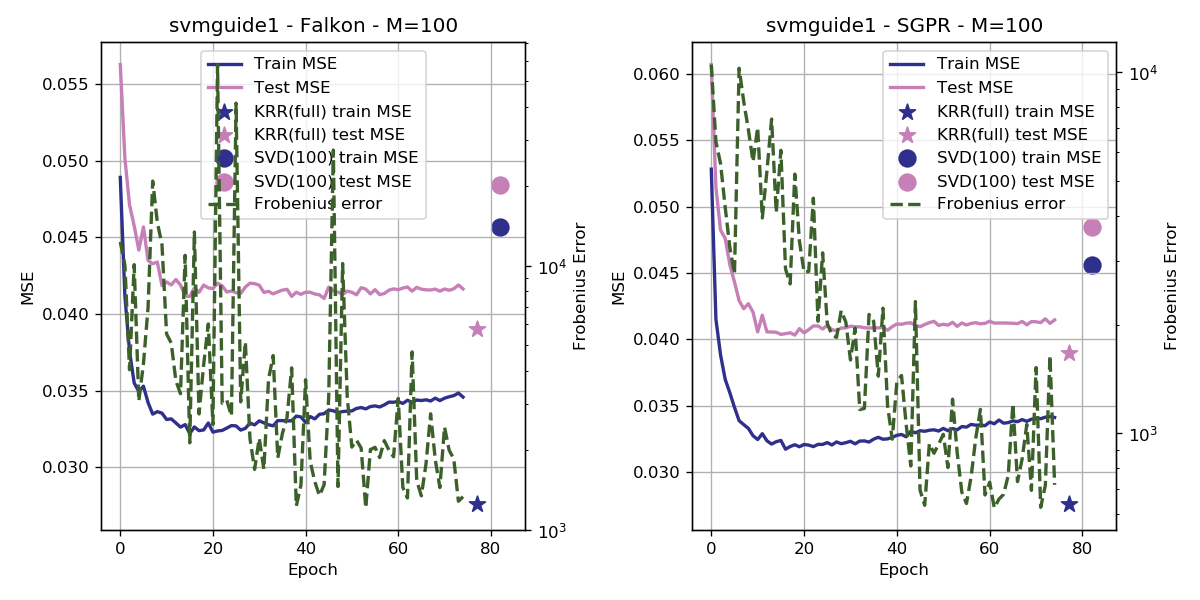

In [142]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
title = get_title("Falkon", M, train_only_trace, dset_name)
opt_plot(res_flk, M, title, figax=(fig, ax[0]))
title = get_title("SGPR", M, train_only_trace, dset_name)
opt_plot(res_sgpr, M, title, figax=(fig, ax[1]))
fig.tight_layout();

<IPython.core.display.Javascript object>


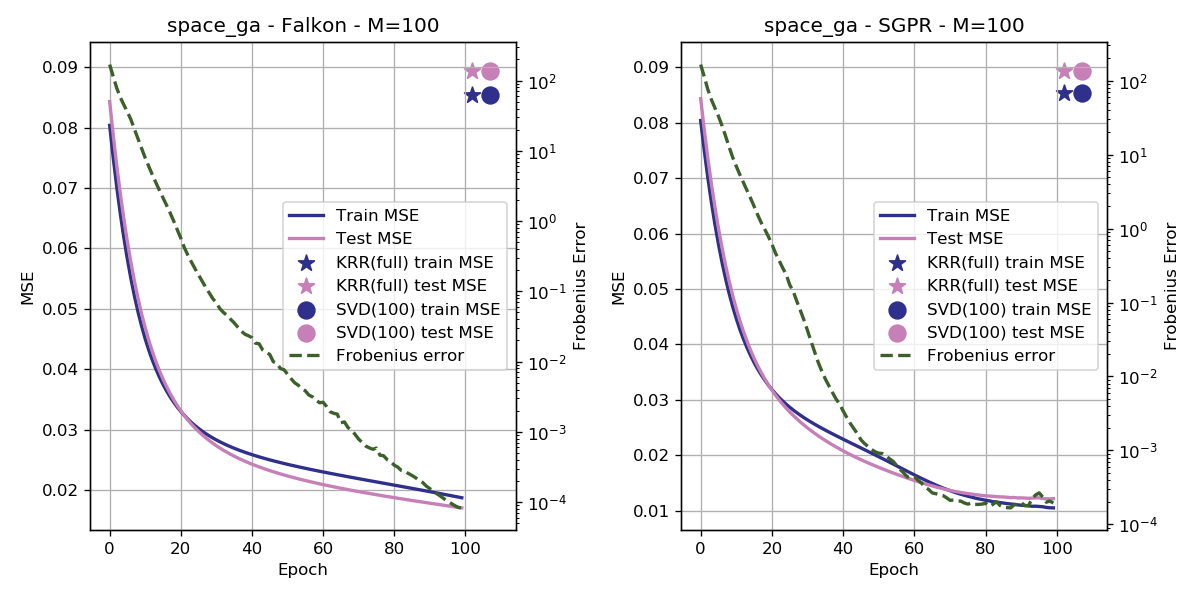

In [94]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
title = get_title("Falkon", M, train_only_trace, dset_name)
opt_plot(res_flk, M, title, figax=(fig, ax[0]))
title = get_title("SGPR", M, train_only_trace, dset_name)
opt_plot(res_sgpr, M, title, figax=(fig, ax[1]))
fig.tight_layout();

<IPython.core.display.Javascript object>


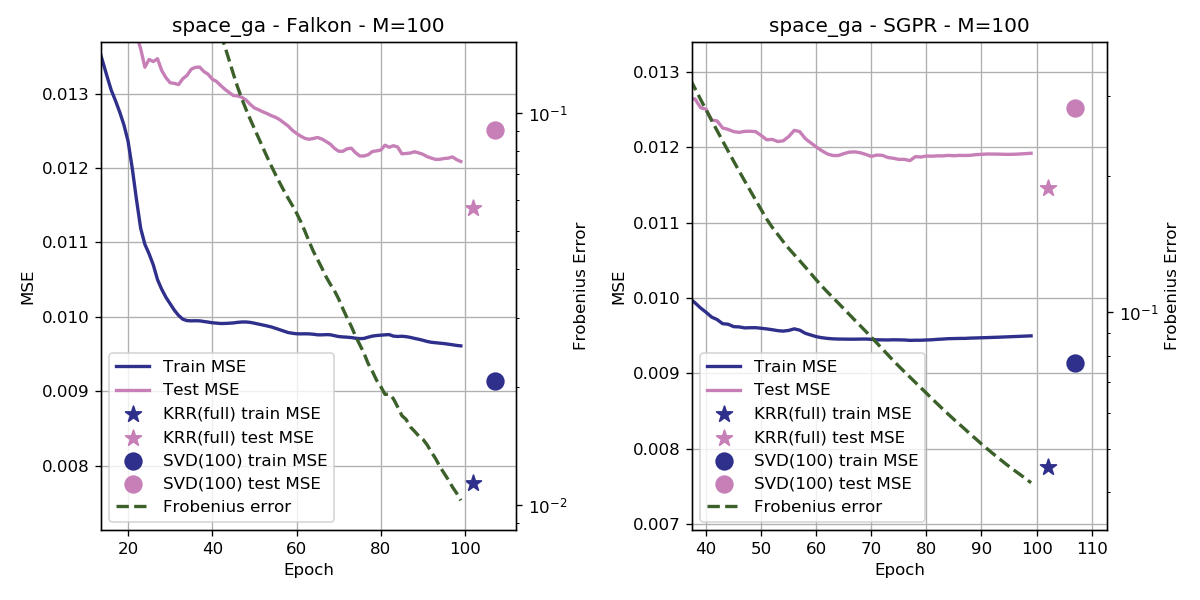

In [43]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
title = get_title("Falkon", M, train_only_trace, dset_name)
opt_plot(res_flk, M, title, figax=(fig, ax[0]))
title = get_title("SGPR", M, train_only_trace, dset_name)
opt_plot(res_sgpr, M, title, figax=(fig, ax[1]))
fig.tight_layout();

<IPython.core.display.Javascript object>


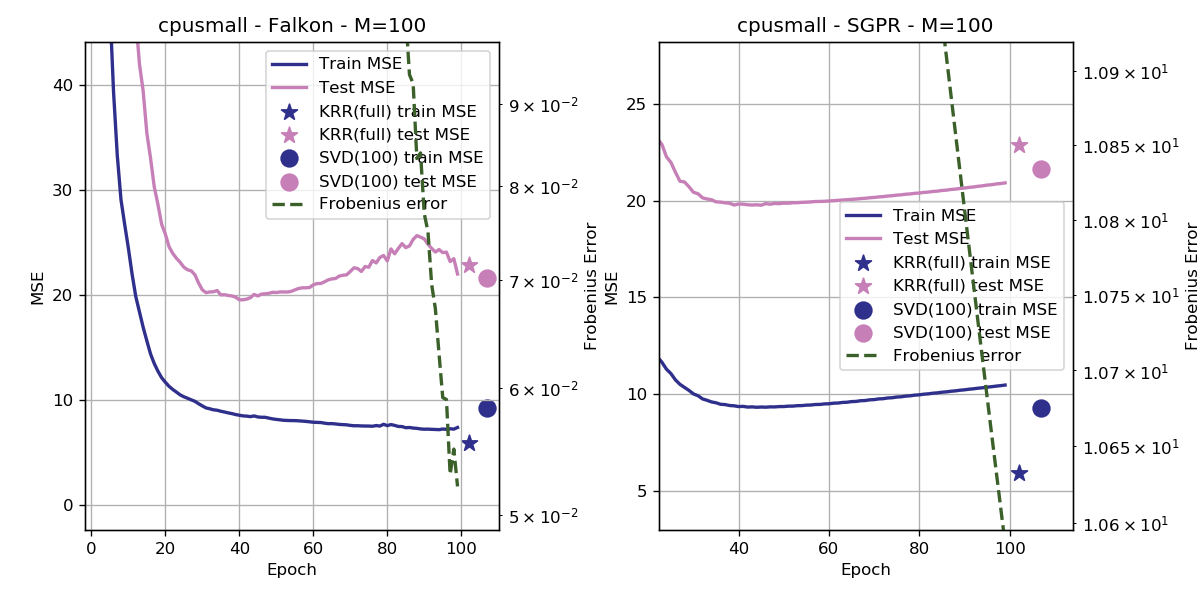

In [39]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
title = get_title("Falkon", M, train_only_trace, dset_name)
opt_plot(res_flk, M, title, figax=(fig, ax[0]))
title = get_title("SGPR", M, train_only_trace, dset_name)
opt_plot(res_sgpr, M, title, figax=(fig, ax[1]))
fig.tight_layout();

<IPython.core.display.Javascript object>


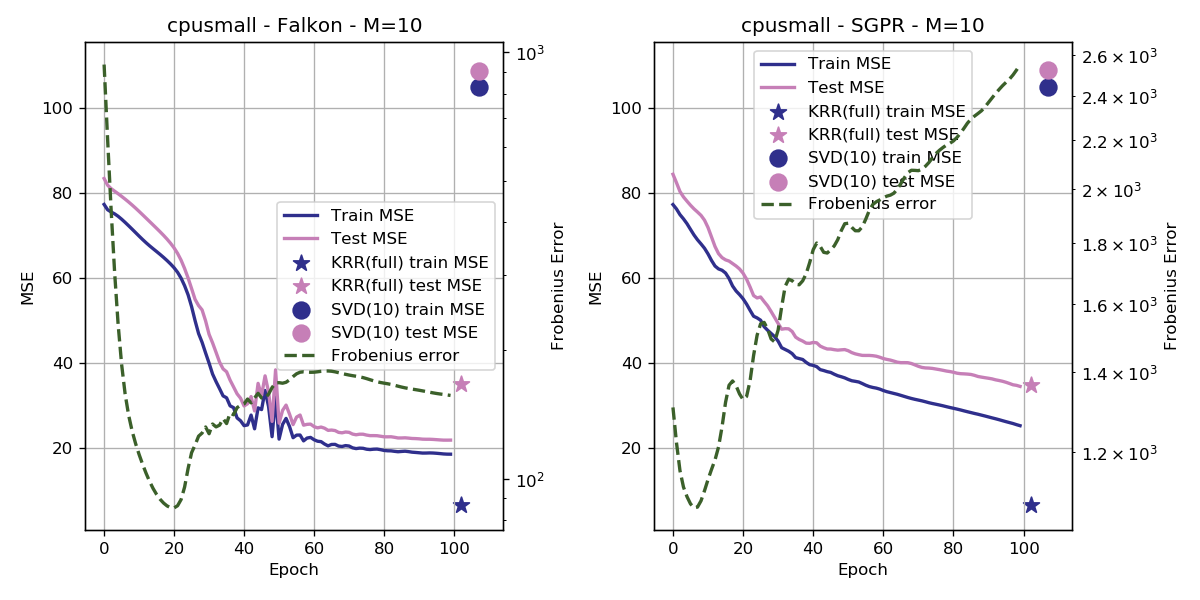

In [35]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
title = get_title("Falkon", M, train_only_trace, dset_name)
opt_plot(res_flk, M, title, figax=(fig, ax[0]))
title = get_title("SGPR", M, train_only_trace, dset_name)
opt_plot(res_sgpr, M, title, figax=(fig, ax[1]))
fig.tight_layout();

<IPython.core.display.Javascript object>


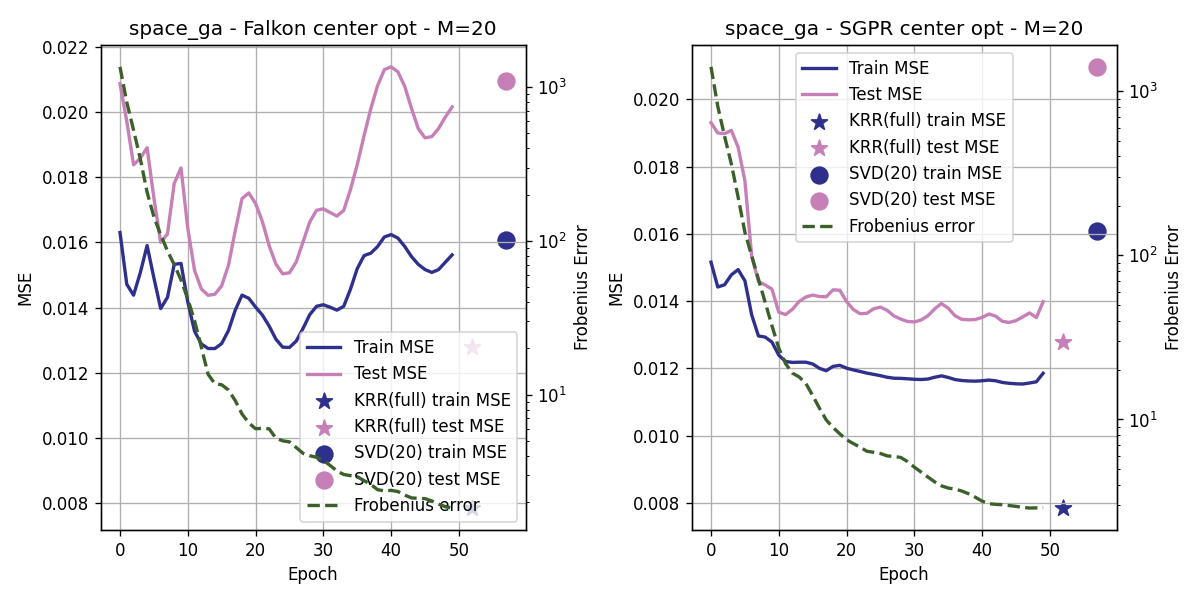

In [58]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
title = get_title("Falkon", M, train_only_trace, dset_name)
opt_plot(res_flk, M, title, figax=(fig, ax[0]))
title = get_title("SGPR", M, train_only_trace, dset_name)
opt_plot(res_sgpr, M, title, figax=(fig, ax[1]))
fig.tight_layout();

/home/giacomo/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


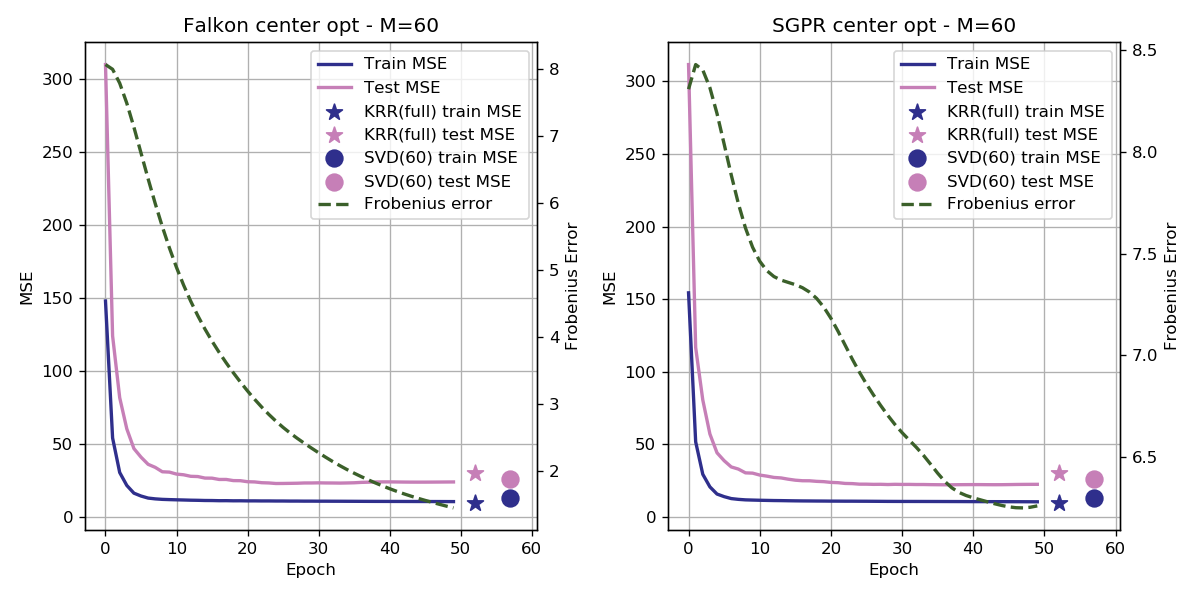

In [1659]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
title = get_title("Falkon", M, train_only_trace)
opt_plot(res_flk, M, title, figax=(fig, ax[0]))
title = get_title("SGPR", M, train_only_trace)
opt_plot(res_sgpr, M, title, figax=(fig, ax[1]))
fig.tight_layout();

/home/giacomo/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


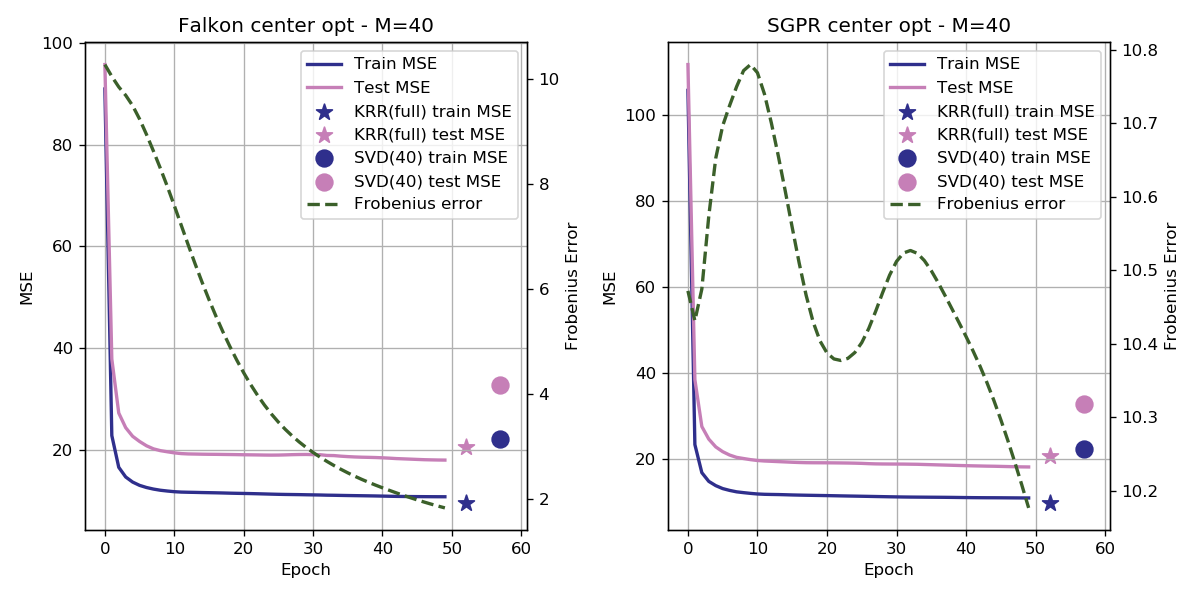

In [1653]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
title = get_title("Falkon", M, train_only_trace)
opt_plot(res_flk, M, title, figax=(fig, ax[0]))
title = get_title("SGPR", M, train_only_trace)
opt_plot(res_sgpr, M, title, figax=(fig, ax[1]))
fig.tight_layout();

/home/giacomo/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


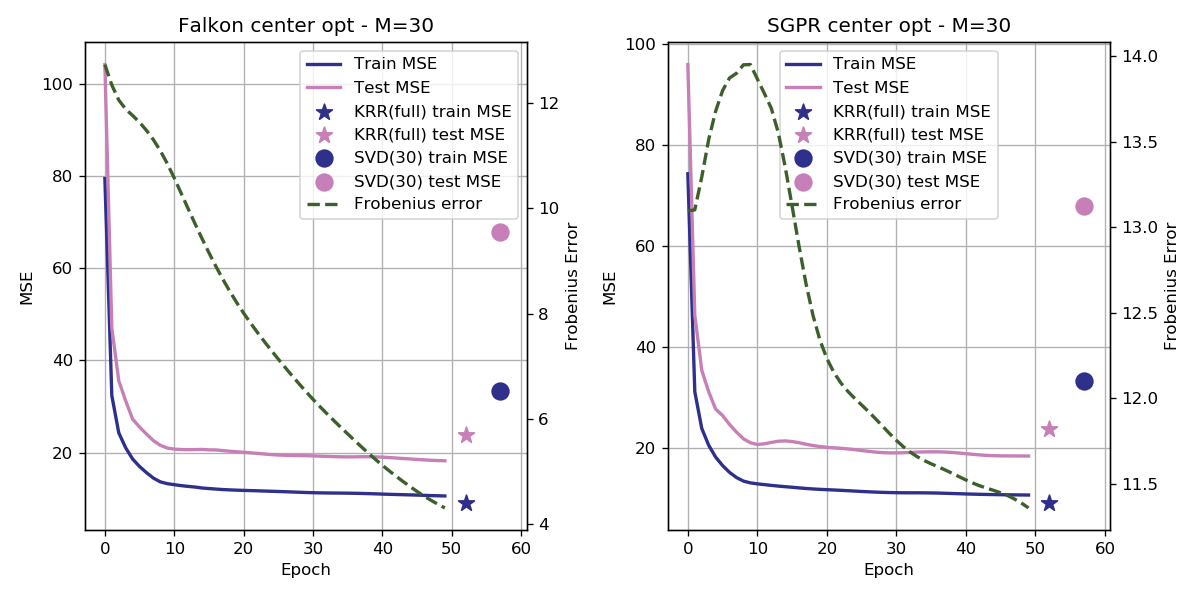

In [1647]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
title = get_title("Falkon", M, train_only_trace)
opt_plot(res_flk, M, title, figax=(fig, ax[0]))
title = get_title("SGPR", M, train_only_trace)
opt_plot(res_sgpr, M, title, figax=(fig, ax[1]))
fig.tight_layout();

<IPython.core.display.Javascript object>


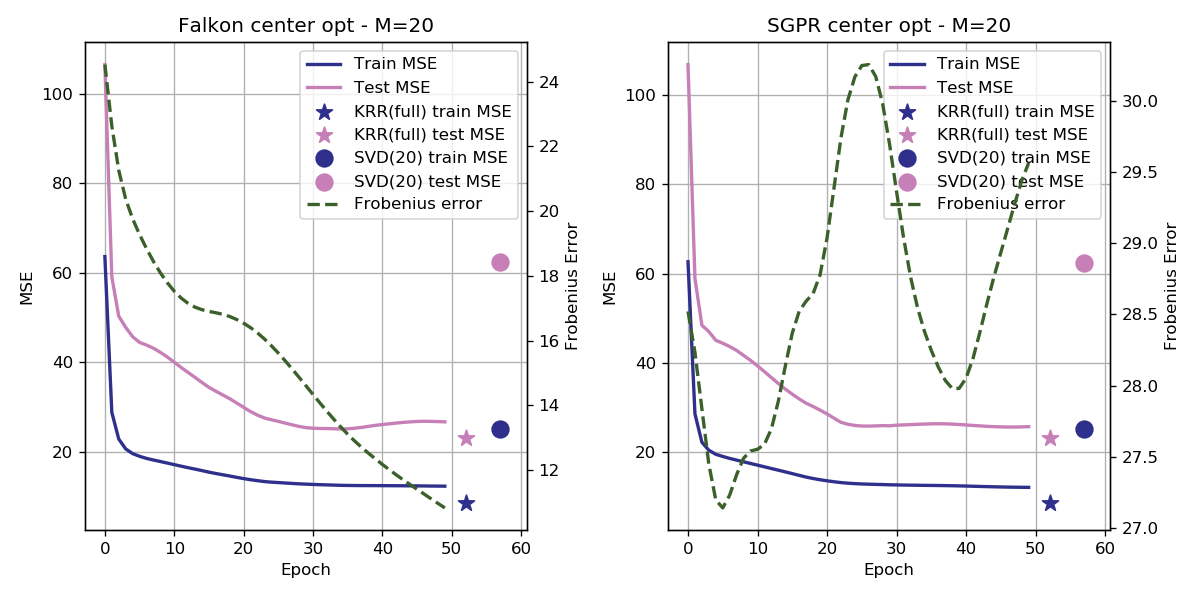

In [1641]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
title = get_title("Falkon", M, train_only_trace)
opt_plot(res_flk, M, title, figax=(fig, ax[0]))
title = get_title("SGPR", M, train_only_trace)
opt_plot(res_sgpr, M, title, figax=(fig, ax[1]))
fig.tight_layout();

In [1626]:
res_flk = train_sgpr_like(opt_model="Falkon", penalty_init=penalty_init, sigma_init=sigma_init, 
                          centers_init=centers_init, only_trace=train_only_trace, lr=learning_rate, 
                          epochs=num_epochs, Xtr=Xtr, Ytr=Ytr, Xts=Xts, Yts=Yts, kernel=kernel)

VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -3.71294e+03
Epoch 0 ( 0.41s) - Sigma 11.000 - Penalty 2.26e-06 - Tr  mse = 68.6537 - Ts  mse = 98.1796
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -3.34330e+03
Epoch 1 ( 0.83s) - Sigma 11.000 - Penalty 2.26e-06 - Tr  mse = 52.6933 - Ts  mse = 64.6181
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -3.13530e+03
Epoch 2 ( 1.27s) - Sigma 11.000 - Penalty 2.26e-06 - Tr  mse = 48.7854 - Ts  mse = 60.2560
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -2.99325e+03
Epoch 3 ( 1.69s) - Sigma 11.000 - Penalty 2.26e-06 - Tr  mse = 48.7269 - Ts  mse = 59.4026
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -2.88373e+03
Epoch 4 ( 2.13s) - Sigma 11.000 - Penalty 2.26e-06 - Tr  mse = 49.0363 - Ts  mse = 58.8953
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -2.79211e+03
Epoch 5 ( 2.78s) - Sigma 11.000 - Penalty 2.26e-06 - Tr  mse = 49.3941 - Ts  mse = 58.6766
VALUE        d_eff 0.00000e+

In [1548]:
res_sgpr = train_sgpr_like(opt_model="SGPR", penalty_init=penalty_init, sigma_init=sigma_init, 
                           centers_init=centers_init, only_trace=train_only_trace, lr=learning_rate, 
                           epochs=num_epochs, Xtr=Xtr, Ytr=Ytr, Xts=Xts, Yts=Yts, kernel=kernel)

VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -6.63416e+04
Epoch 0 ( 0.47s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 77.9894 - Ts  mse = 92.9177
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -5.59427e+04
Epoch 1 ( 0.91s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 61.5331 - Ts  mse = 64.2384
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -5.11572e+04
Epoch 2 ( 1.36s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 58.9901 - Ts  mse = 65.7682
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -4.79725e+04
Epoch 3 ( 1.81s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 59.9734 - Ts  mse = 65.6023
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -4.54046e+04
Epoch 4 ( 2.26s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 61.1089 - Ts  mse = 67.4254
VALUE        d_eff 0.00000e+00 - loss 0.00000e+00 - trace -4.31272e+04
Epoch 5 ( 2.71s) - Sigma 8.000 - Penalty 3.06e-07 - Tr  mse = 62.0902 - Ts  mse = 68.2037
VALUE        d_eff 0.00000e+00 - l

<IPython.core.display.Javascript object>


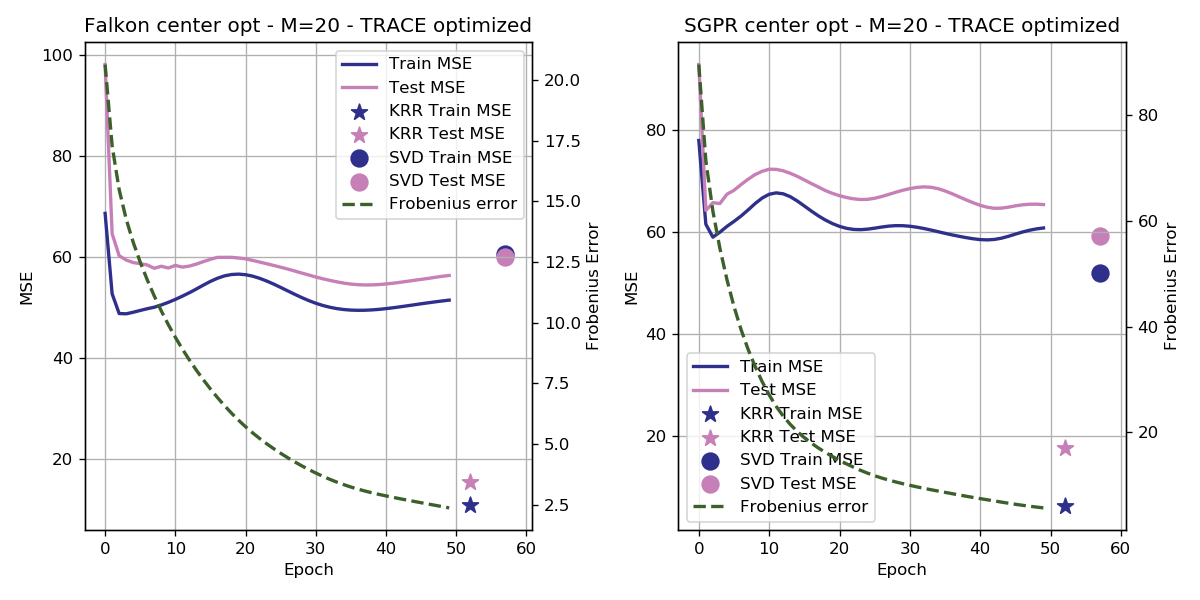

In [1627]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
title = get_title("Falkon", M, train_only_trace)
opt_plot(res_flk, title, figax=(fig, ax[0]))
title = get_title("SGPR", M, train_only_trace)
opt_plot(res_sgpr, title, figax=(fig, ax[1]));

<IPython.core.display.Javascript object>


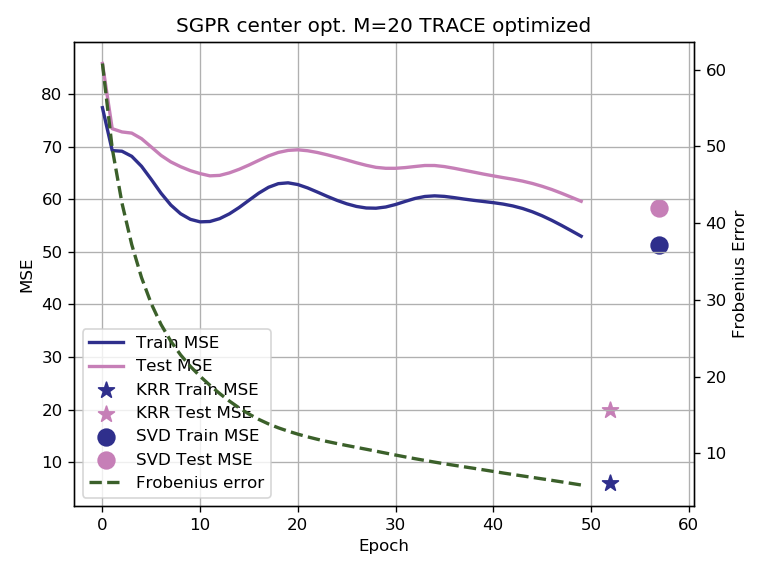

In [1532]:
title = "%s center opt. M=%d" % (opt_model, M)
if train_only_trace:
    title += " TRACE optimized"
fig, ax = opt_plot(train_errors, test_errors, fro_errors, tr_err_krr, ts_err_krr, tr_err_svd, ts_err_svd, num_epochs, title)
fig.tight_layout()

<IPython.core.display.Javascript object>


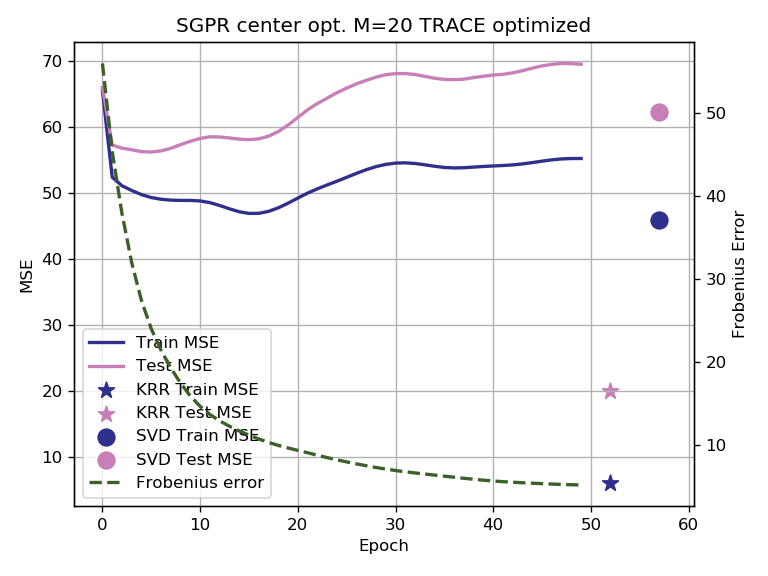

In [1510]:
fig, ax = plt.subplots()
ax.plot(range(num_epochs), train_errors, label="Train MSE", color="#2f2f8c", lw=2)
ax.plot(range(num_epochs), test_errors, label="Test MSE", color="#c67fb7", lw=2)

ax1 = ax.twinx()
ax1.plot(range(num_epochs), fro_errors, color="#3b602a", linestyle="--", label="Frobenius error", lw=2)


ax.scatter(num_epochs + 2, tr_err_krr, label="KRR Train MSE", s=100, marker="*", color="#2f2f8c")
ax.scatter(num_epochs + 2, ts_err_krr, label="KRR Test MSE", s=100, marker="*", color="#c67fb7")

ax.scatter(num_epochs + 7, tr_err_svd, label="SVD Train MSE", s=100, marker="o", color="#2f2f8c")
ax.scatter(num_epochs + 7, ts_err_svd, label="SVD Test MSE", s=100, marker="o", color="#c67fb7")


lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax1.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc="best")

ax.grid()
ax.set_xlabel("Epoch")
ax.set_ylabel("MSE")
ax1.set_ylabel("Frobenius Error")
title = "SGPR center opt. M=%d" % (M)
if train_only_trace:
    title += " TRACE optimized"
ax.set_title(title)
fig.tight_layout()

<IPython.core.display.Javascript object>


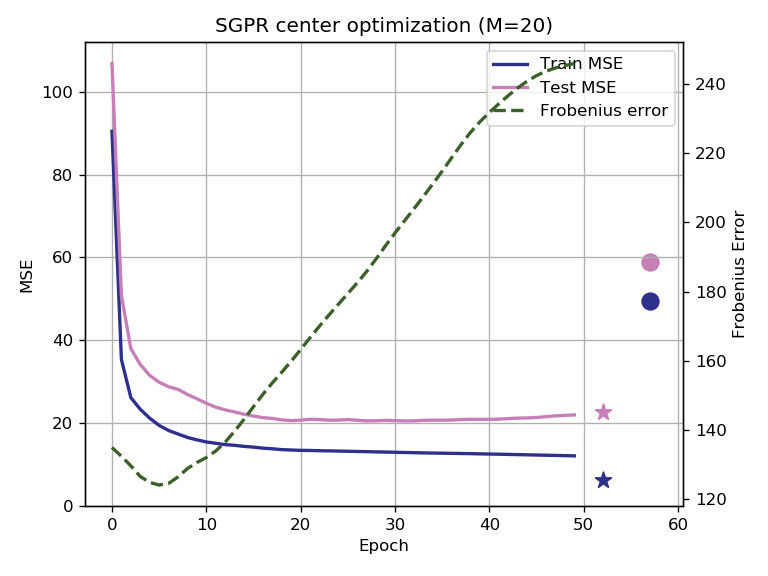

In [1495]:
fig, ax = plt.subplots()
ax.plot(range(num_epochs), train_errors, label="Train MSE", color="#2f2f8c", lw=2)
ax.plot(range(num_epochs), test_errors, label="Test MSE", color="#c67fb7", lw=2)

ax1 = ax.twinx()
ax1.plot(range(num_epochs), fro_errors, color="#3b602a", linestyle="--", label="Frobenius error", lw=2)

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax1.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc="best")

ax.scatter(num_epochs + 2, tr_err_krr, label="KRR Train MSE", s=100, marker="*", color="#2f2f8c")
ax.scatter(num_epochs + 2, ts_err_krr, label="KRR Test MSE", s=100, marker="*", color="#c67fb7")

ax.scatter(num_epochs + 7, tr_err_svd, label="SVD Train MSE", s=100, marker="o", color="#2f2f8c")
ax.scatter(num_epochs + 7, ts_err_svd, label="SVD Test MSE", s=100, marker="o", color="#c67fb7")

ax.grid()
ax.set_xlabel("Epoch")
ax.set_ylabel("MSE")
ax1.set_ylabel("Frobenius Error")
ax.set_title("SGPR center optimization (M=%d)" % (M))
fig.tight_layout()

<IPython.core.display.Javascript object>


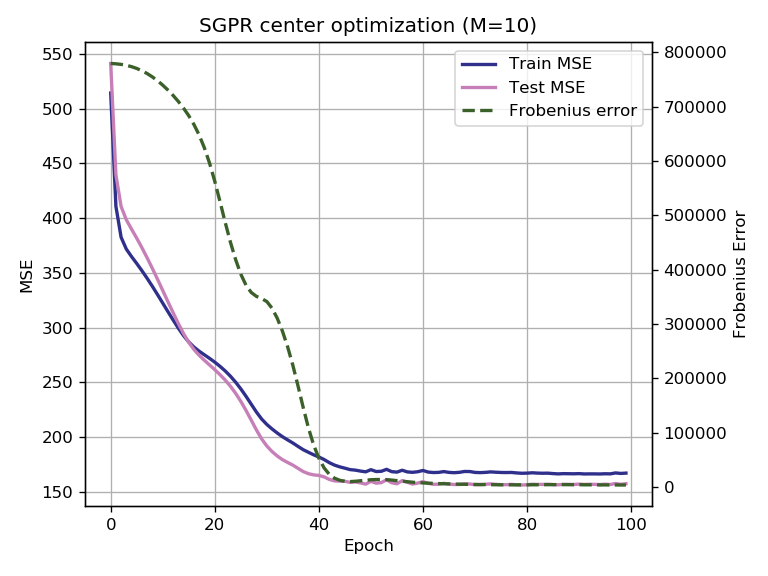

In [899]:
fig, ax = plt.subplots()
ax.plot(range(num_epochs), train_errors, label="Train MSE", color="#2f2f8c", lw=2)
ax.plot(range(num_epochs), test_errors, label="Test MSE", color="#c67fb7", lw=2)

ax1 = ax.twinx()
ax1.plot(range(num_epochs), fro_errors, color="#3b602a", linestyle="--", label="Frobenius error", lw=2)

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax1.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc="best")

ax.grid()
ax.set_xlabel("Epoch")
ax.set_ylabel("MSE")
ax1.set_ylabel("Frobenius Error")
ax.set_title("SGPR center optimization (M=%d)" % (M))
fig.tight_layout()